<a href="https://colab.research.google.com/github/neutrinoox/projet7-scoring/blob/main/notebooks/V_Maxime_2_notebook_modelisation_092025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contexte et objectifs
   Ce notebook prépare un pipeline reproductible pour le scoring de crédit. Il structure le chargement des données, le feature engineering, puis les baselines de modélisation.

In [3]:
import os
from pathlib import Path
import pandas as pd

In [4]:
# Définit le chemin racine des données
DATA_DIR = Path("data")

# Crée le dossier de cache
DATA_DIR.mkdir(exist_ok=True)

In [5]:
# Définit le dictionnaire des fichiers à charger
FILES = {
    "application_train": "application_train.csv",
    "application_test": "application_test.csv",
    "bureau": "bureau.csv",
    "bureau_balance": "bureau_balance.csv",
    "credit_card_balance": "credit_card_balance.csv",
    "installments_payments": "installments_payments.csv",
    "POS_CASH_balance": "POS_CASH_balance.csv",
    "previous_application": "previous_application.csv",
    "HomeCredit_columns_description": "HomeCredit_columns_description.csv",
    "sample_submission": "sample_submission.csv",
}

# Charge tous les fichiers dans un dictionnaire
raw_data = {}
for name, filename in FILES.items():
    # Construit le chemin final du fichier source
    filepath = DATA_DIR / filename
    # Lit le CSV concerné en conservant les types par défaut
    try:
        raw_data[name] = pd.read_csv(filepath, encoding="utf-8", sep=',', low_memory=False, on_bad_lines='warn')
    except UnicodeDecodeError:
        raw_data[name] = pd.read_csv(filepath, encoding="latin1", sep=',', low_memory=False, on_bad_lines='warn')

In [6]:
def eda_basique(df, nom_df="DataFrame"):
    print(f"\n--- Analyse de {nom_df} ---")

    # Dimensions du DataFrame
    print(f"Shape (lignes, colonnes) : {df.shape}")

    # Liste des colonnes
    print("\n Colonnes :")
    print(df.columns.tolist())

    # Valeurs manquantes
    print("\n Valeurs manquantes (par colonne) :")
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    display(missing.to_frame(name="Nb de NaN"))

    # Statistiques descriptives
    print("\n Statistiques descriptives (variables numériques) :")
    display(df.describe().transpose())

    # Exemple de données
    print("\n Extrait (premières lignes) :")
    display(df.head())

In [7]:
eda_basique(raw_data['sample_submission'], "sample_submission")


--- Analyse de sample_submission ---
Shape (lignes, colonnes) : (48744, 2)

 Colonnes :
['SK_ID_CURR', 'TARGET']

 Valeurs manquantes (par colonne) :


,Nb de NaN



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,48744.0,277796.67635,103169.547296,100001.0,188557.75,277549.0,367555.5,456250.0
TARGET,48744.0,0.50000,0.000000,0.5,0.50,0.5,0.5,0.5



 Extrait (premières lignes) :


,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


## Analyse du fichier `sample_submission.csv`

Ce fichier contient **2 colonnes** :
- `SK_ID_CURR` : l’identifiant unique d’un client.
- `TARGET` : une valeur de prédiction **fictive**, ici toujours à `0.5`.

Ce fichier est un **exemple de format de soumission** pour des compétitions de type Kaggle. Il montre à quoi devrait ressembler un fichier contenant les prédictions finales du modèle pour le jeu de test (`application_test.csv`).

---

###  Pourquoi ce fichier ne sera **pas utilisé** dans le projet

Dans notre contexte, on ne participe **pas à une compétition Kaggle**, mais on développe un **dashboard interactif** pour expliquer les décisions d’octroi de crédit.  
Nous allons donc nous appuyer sur :
- les **vraies données clients** (`application_train.csv`, `application_test.csv`),
- et notre **modèle/API existant** pour produire les scores.

Le fichier `sample_submission.csv` ne nous est **d’aucune utilité directe** ici.

In [8]:
eda_basique(raw_data['POS_CASH_balance'], "POS_CASH_balance")


--- Analyse de POS_CASH_balance ---
Shape (lignes, colonnes) : (10001358, 8)

 Colonnes :
['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']

 Valeurs manquantes (par colonne) :


,Nb de NaN
CNT_INSTALMENT_FUTURE,26087
CNT_INSTALMENT,26071



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,10001358.0,1.903217e+06,535846.530722,1000001.0,1434405.0,1896565.0,2368963.0,2843499.0
SK_ID_CURR,10001358.0,2.784039e+05,102763.745090,100001.0,189550.0,278654.0,367429.0,456255.0
MONTHS_BALANCE,10001358.0,-3.501259e+01,26.066570,-96.0,-54.0,-28.0,-13.0,-1.0
CNT_INSTALMENT,9975287.0,1.708965e+01,11.995056,1.0,10.0,12.0,24.0,92.0
CNT_INSTALMENT_FUTURE,9975271.0,1.048384e+01,11.109058,0.0,3.0,7.0,14.0,85.0
SK_DPD,10001358.0,1.160693e+01,132.714043,0.0,0.0,0.0,0.0,4231.0
SK_DPD_DEF,10001358.0,6.544684e-01,32.762491,0.0,0.0,0.0,0.0,3595.0



 Extrait (premières lignes) :


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


## Analyse du fichier `POS_CASH_balance.csv`

Ce fichier contient des **informations mensuelles** sur les crédits **POS (point of sale)** ou **CASH** contractés par les clients.

Chaque ligne correspond à **un mois de suivi d’un crédit** (d’où la colonne `MONTHS_BALANCE`).

| Colonne | Signification | Utile pour le projet ? |
|---------|---------------|------------------------|
| `SK_ID_PREV` | ID de la demande de crédit (liée à un client) | Non, identifiant technique |
| `SK_ID_CURR` | ID du client (clé principale) | Oui, pour relier au client |
| `MONTHS_BALANCE` | Mois relatif : 0 = mois actuel, -1 = mois précédent, etc. | Peut être utile si analyse temporelle |
| `CNT_INSTALMENT` | Nombre total d’échéances prévues du crédit | Potentiellement utile (longueur du crédit) |
| `CNT_INSTALMENT_FUTURE` | Nombre d’échéances restantes à ce moment-là | Oui (endettement restant) |
| `NAME_CONTRACT_STATUS` | Statut du crédit ce mois-là (Active, Completed, etc.) | Oui (situation actuelle ou passée) |
| `SK_DPD` | Jours de retard de paiement (jours de retard > 0) | Oui (comportement de remboursement) |
| `SK_DPD_DEF` | Jours de retard "défaut" (dépassant un seuil critique)  Oui (indicateur fort de défaut) |

---

- Les colonnes `SK_DPD` et `SK_DPD_DEF` sont intéressantes pour mesurer **la fiabilité de remboursement passée** d’un client.
- Les colonnes `CNT_INSTALMENT` et `CNT_INSTALMENT_FUTURE` donnent une idée de **l’état d’un crédit en cours**.
- Le statut du contrat (`NAME_CONTRACT_STATUS`) permet de savoir si le crédit est **encore actif ou terminé**.

- Ce fichier contient **beaucoup de lignes (plus de 100 000)** car il suit les crédits mois par mois.
- Il faudrait le **résumer** pour pouvoir l’utiliser dans le dashboard (par exemple : nombre de crédits actifs, total de jours de retard moyen, etc.).
- Cela demande un **prétraitement avancé** (agrégations par client), ce qui dépasse le besoin immédiat du dashboard centré sur **l’interprétation d’un score individuel**.

**Conclusion** : Ce fichier est **intéressant pour enrichir un modèle**, mais il ne sera **pas utilisé directement** dans le dashboard sans prétraitement.

In [9]:
eda_basique(raw_data['installments_payments'], "installments_payments")


--- Analyse de installments_payments ---
Shape (lignes, colonnes) : (13605401, 8)

 Colonnes :
['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']

 Valeurs manquantes (par colonne) :


,Nb de NaN
DAYS_ENTRY_PAYMENT,2905
AMT_PAYMENT,2905



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,13605401.0,1.903365e+06,536202.905546,1000001.0,1434191.000,1896520.000,2369094.000,2843499.000
SK_ID_CURR,13605401.0,2.784449e+05,102718.310411,100001.0,189639.000,278685.000,367530.000,456255.000
NUM_INSTALMENT_VERSION,13605401.0,8.566373e-01,1.035216,0.0,0.000,1.000,1.000,178.000
NUM_INSTALMENT_NUMBER,13605401.0,1.887090e+01,26.664067,1.0,4.000,8.000,19.000,277.000
DAYS_INSTALMENT,13605401.0,-1.042270e+03,800.946284,-2922.0,-1654.000,-818.000,-361.000,-1.000
DAYS_ENTRY_PAYMENT,13602496.0,-1.051114e+03,800.585883,-4921.0,-1662.000,-827.000,-370.000,-1.000
AMT_INSTALMENT,13605401.0,1.705091e+04,50570.254429,0.0,4226.085,8884.080,16710.210,3771487.845
AMT_PAYMENT,13602496.0,1.723822e+04,54735.783981,0.0,3398.265,8125.515,16108.425,3771487.845



 Extrait (premières lignes) :


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


## Analyse du fichier `installments_payments.csv`

Ce fichier contient des informations détaillées sur les **paiements effectués par les clients** sur leurs crédits précédents, échéance par échéance.

Chaque ligne correspond à un **paiement prévu vs réel** pour un crédit donné.

---

| Colonne | Signification | Utile pour le projet ? |
|---------|---------------|------------------------|
| `SK_ID_PREV` | ID de la demande de crédit |  Non |
| `SK_ID_CURR` | ID du client (clé principale) | Oui |
| `NUM_INSTALMENT_VERSION` | Version de l’échéancier | Non |
| `NUM_INSTALMENT_NUMBER` | Numéro de l’échéance (1er, 2e, etc.) | Pas directement |
| `DAYS_INSTALMENT` | Jour prévu pour l’échéance (relatif au jour actuel) | Oui, Pour évaluer la ponctualité |
| `DAYS_ENTRY_PAYMENT` | Jour réel du paiement effectué | Oui, Pour calculer le retard |
| `AMT_INSTALMENT` | Montant dû pour cette échéance | Oui, indice du poids des mensualités |
| `AMT_PAYMENT` | Montant réellement payé | Oui, Pour savoir si le paiement a été partiel ou total |

---

Ce fichier est **extrêmement utile pour comprendre les habitudes de remboursement** des clients dans le passé :
- Ponctualité : en comparant `DAYS_INSTALMENT` et `DAYS_ENTRY_PAYMENT` → si le client est souvent en retard.
- Paiements partiels : en comparant `AMT_INSTALMENT` et `AMT_PAYMENT`.

Je peux en déduire des **indicateurs puissants** pour enrichir le modèle ou le dashboard :
- Moyenne de retard de paiement.
- % de paiements effectués en totalité.
- Nombre d’échéances payées en retard.

Comme `POS_CASH_balance`, ce fichier contient **plusieurs lignes par client**. Il faut donc :
- Faire des **agrégations par client** (via `SK_ID_CURR`) pour le résumer.
- Ensuite, intégrer ces indicateurs dans le modèle ou le dashboard.

In [10]:
eda_basique(raw_data['credit_card_balance'], "credit_card_balance")


--- Analyse de credit_card_balance ---
Shape (lignes, colonnes) : (3840312, 23)

 Colonnes :
['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']

 Valeurs manquantes (par colonne) :


,Nb de NaN
AMT_PAYMENT_CURRENT,767988
AMT_DRAWINGS_ATM_CURRENT,749816
AMT_DRAWINGS_OTHER_CURRENT,749816
AMT_DRAWINGS_POS_CURRENT,749816
CNT_DRAWINGS_ATM_CURRENT,749816
CNT_DRAWINGS_POS_CURRENT,749816
CNT_DRAWINGS_OTHER_CURRENT,749816
AMT_INST_MIN_REGULARITY,305236
CNT_INSTALMENT_MATURE_CUM,305236



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,3840312.0,1.904504e+06,536469.470563,1000018.000,1434385.00,1897122.0,2.369328e+06,2843496.000
SK_ID_CURR,3840312.0,2.783242e+05,102704.475133,100006.000,189517.00,278396.0,3.675800e+05,456250.000
MONTHS_BALANCE,3840312.0,-3.452192e+01,26.667751,-96.000,-55.00,-28.0,-1.100000e+01,-1.000
AMT_BALANCE,3840312.0,5.830016e+04,106307.031025,-420250.185,0.00,0.0,8.904669e+04,1505902.185
AMT_CREDIT_LIMIT_ACTUAL,3840312.0,1.538080e+05,165145.699523,0.000,45000.00,112500.0,1.800000e+05,1350000.000
AMT_DRAWINGS_ATM_CURRENT,3090496.0,5.961325e+03,28225.688579,-6827.310,0.00,0.0,0.000000e+00,2115000.000
AMT_DRAWINGS_CURRENT,3840312.0,7.433388e+03,33846.077334,-6211.620,0.00,0.0,0.000000e+00,2287098.315
AMT_DRAWINGS_OTHER_CURRENT,3090496.0,2.881696e+02,8201.989345,0.000,0.00,0.0,0.000000e+00,1529847.000
AMT_DRAWINGS_POS_CURRENT,3090496.0,2.968805e+03,20796.887047,0.000,0.00,0.0,0.000000e+00,2239274.160
AMT_INST_MIN_REGULARITY,3535076.0,3.540204e+03,5600.154122,0.000,0.00,0.0,6.633911e+03,202882.005



 Extrait (premières lignes) :


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


## Analyse du fichier `credit_card_balance.csv`

Ce fichier contient des **informations mensuelles sur les cartes de crédit** détenues par les clients.

Chaque ligne représente **l’état d’un compte carte de crédit** pour **un mois donné**, ce qui explique pourquoi il y a plusieurs lignes par client.

---

### Colonnes principales et leur signification

| Colonne | Description | Utile pour le dashboard ? |
|---------|-------------|---------------------------|
| `SK_ID_PREV` | ID du crédit (lié au compte carte) | Non |
| `SK_ID_CURR` | ID du client | Oui |
| `MONTHS_BALANCE` | Mois (relatif au mois actuel, 0 = actuel) | Non directement |
| `AMT_BALANCE` | Montant total dû sur la carte | Oui |
| `AMT_CREDIT_LIMIT_ACTUAL` | Limite de crédit actuelle | Oui |
| `AMT_DRAWINGS_ATM_CURRENT` | Montant retiré au distributeur ce mois |Potentiellement |
| `AMT_DRAWINGS_CURRENT` | Montant total retiré | Peut indiquer l’utilisation active |
| `AMT_DRAWINGS_OTHER_CURRENT` | Montants retirés ailleurs (online, etc.) | Trop spécifique |
| `AMT_DRAWINGS_POS_CURRENT` | Montants dépensés en magasin | Peut indiquer habitudes de conso |
| `AMT_INST_MIN_REGULARITY` | Montant minimum à payer ce mois | Oui |
| `AMT_PAYMENT_CURRENT` | Montant effectivement payé | Oui |
| `AMT_PAYMENT_TOTAL_CURRENT` | Paiement total (y compris intérêts) | Oui |
| `AMT_RECEIVABLE_PRINCIPAL` | Principal dû (hors intérêts) | Oui |
| `AMT_RECIVABLE` | Montant total à récupérer (possible doublon) |Non, Doublon probable |
| `AMT_TOTAL_RECEIVABLE` | Total dû client (intérêts inclus) | Oui |
| `CNT_DRAWINGS_ATM_CURRENT` | Nombre de retraits au DAB ce mois | Trop granulaire |
| `CNT_DRAWINGS_CURRENT` | Nombre total d'opérations ce mois | Peut être utile |
| `CNT_DRAWINGS_OTHER_CURRENT` | Autres retraits | Non |
| `CNT_DRAWINGS_POS_CURRENT` | Nombre d’achats en magasin | Non |
| `CNT_INSTALMENT_MATURE_CUM` | Nb d'échéances arrivées à terme | Pas pertinent |
| `NAME_CONTRACT_STATUS` | Statut du compte (Active, Closed) | Oui |
| `SK_DPD` | Jours de retard de paiement ce mois | Très utile |
| `SK_DPD_DEF` | Retards "défaut" ce mois | Très utile |

---

Ce fichier permet de suivre **le comportement de gestion des cartes de crédit**, ce qui est **fortement lié au risque de défaut** :
- Est-ce que le client paie ce qu’il doit ? (`AMT_PAYMENT_CURRENT`)
- A-t-il accumulé du solde impayé ? (`AMT_BALANCE`)
- Fait-il souvent des **retards de paiement** ? (`SK_DPD`)
- Utilise-t-il **la totalité de sa limite de crédit** ? (`AMT_BALANCE` vs `AMT_CREDIT_LIMIT_ACTUAL`)

Comme les autres fichiers mensuels (`POS_CASH_balance`, `installments_payments`), ce fichier contient **plusieurs lignes par client**.

Il devra être **agrégé** par client (via `SK_ID_CURR`) avant utilisation dans le dashboard.  
Je peux en tirer par exemple :
- Solde moyen de la carte (`mean(AMT_BALANCE)`),
- % de mois avec retard (`mean(SK_DPD > 0)`),
- Taux d'utilisation de la limite (`AMT_BALANCE / AMT_CREDIT_LIMIT_ACTUAL`).

In [11]:
eda_basique(raw_data['HomeCredit_columns_description'], "HomeCredit_columns_description")


--- Analyse de HomeCredit_columns_description ---
Shape (lignes, colonnes) : (219, 5)

 Colonnes :
['Unnamed: 0', 'Table', 'Row', 'Description', 'Special']

 Valeurs manquantes (par colonne) :


,Nb de NaN
Special,133



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,219.0,111.981735,63.395726,1.0,57.5,112.0,166.5,221.0



 Extrait (premières lignes) :


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


## Analyse du fichier `HomeCredit_columns_description.csv`

Ce fichier sert de **dictionnaire de données**.  
Il décrit chaque colonne présente dans les fichiers principaux du projet (`application_train`, `bureau`, etc.).


| Colonne | Signification |
|---------|----------------|
| `Table` | Nom du fichier où se trouve la colonne décrite |
| `Row` | Nom de la colonne concernée |
| `Description` | Brève explication de ce que contient cette colonne |
| `Special` | Informations supplémentaires éventuelles (souvent vide) |


Ce fichier est **très utile en phase d’exploration**, notamment pour :
- Comprendre rapidement le sens des colonnes techniques (ex : `SK_DPD_DEF`, `AMT_INSTALMENT`, etc.).
- Identifier les variables catégorielles ou booléennes.
- Repérer les colonnes redondantes ou inutiles.

Il ne sera **pas utilisé directement** dans le dashboard ou dans le modèle.

Ce fichier **ne contient pas de données clients**, uniquement des **métadonnées**.  
Il est donc à consulter manuellement pour mieux travailler sur les autres fichiers.

In [12]:
eda_basique(raw_data['bureau_balance'], "bureau_balance")


--- Analyse de bureau_balance ---
Shape (lignes, colonnes) : (27299925, 3)

 Colonnes :
['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']

 Valeurs manquantes (par colonne) :


,Nb de NaN



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_BUREAU,27299925.0,6.036297e+06,492348.856904,5001709.0,5730933.0,6070821.0,6431951.0,6842888.0
MONTHS_BALANCE,27299925.0,-3.074169e+01,23.864509,-96.0,-46.0,-25.0,-11.0,0.0



 Extrait (premières lignes) :


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


## Analyse du fichier `HomeCredit_columns_description.csv`

Ce fichier sert de **dictionnaire de données**.  
Il décrit chaque colonne présente dans les fichiers principaux du projet (`application_train`, `bureau`, etc.).


| Colonne | Signification |
|---------|----------------|
| `Table` | Nom du fichier où se trouve la colonne décrite |
| `Row` | Nom de la colonne concernée |
| `Description` | Brève explication de ce que contient cette colonne |
| `Special` | Informations supplémentaires éventuelles (souvent vide) |


Ce fichier est **très utile en phase d’exploration**, notamment pour :
- Comprendre rapidement le sens des colonnes techniques (ex : `SK_DPD_DEF`, `AMT_INSTALMENT`, etc.).
- Identifier les variables catégorielles ou booléennes.
- Repérer les colonnes redondantes ou inutiles.

Il ne sera **pas utilisé directement** dans le dashboard ou dans le modèle.

Ce fichier **ne contient pas de données clients**, uniquement des **métadonnées**.  
Il est donc à consulter manuellement pour mieux travailler sur les autres fichiers.

In [13]:
eda_basique(raw_data['bureau_balance'], "bureau_balance")


--- Analyse de bureau_balance ---
Shape (lignes, colonnes) : (27299925, 3)

 Colonnes :
['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']

 Valeurs manquantes (par colonne) :


,Nb de NaN



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_BUREAU,27299925.0,6.036297e+06,492348.856904,5001709.0,5730933.0,6070821.0,6431951.0,6842888.0
MONTHS_BALANCE,27299925.0,-3.074169e+01,23.864509,-96.0,-46.0,-25.0,-11.0,0.0



 Extrait (premières lignes) :


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


## Analyse du fichier `bureau_balance.csv`

Ce fichier contient des informations **mensuelles** sur l’évolution des crédits répertoriés dans le fichier `bureau.csv`.

Chaque ligne correspond à **un mois de suivi d’un crédit externe** (non contracté chez Prêt à Dépenser).


| Colonne | Description | Utile pour le projet ? |
|---------|-------------|------------------------|
| `SK_ID_BUREAU` | Identifiant du crédit dans `bureau.csv` | Oui, Pour faire une jointure |
| `MONTHS_BALANCE` | Mois de l’observation (0 = actuel, -1 = mois précédent...) | Non, Trop détaillé pour le dashboard |
| `STATUS` | Statut du crédit ce mois-là (ex : "C" = en cours, "0", "1", etc. = niveaux de retard) | Oui (comportement de paiement) |

---

Le fichier permet de **suivre l’historique d’un crédit externe** mois après mois :
- Le statut `"C"` indique que le crédit était actif mais à jour.
- Des valeurs numériques (`"0"`, `"1"`, ..., `"5"`) indiquent des mois de **retard de paiement**.
- `"X"` ou `NaN` peuvent signaler **informations manquantes ou clôtures**.

En analysant `STATUS`, on peut construire des indicateurs par client :
- Nombre de mois en retard,
- Retard maximum atteint,
- Ratio de mois à l’heure / total,
- Nombre de crédits "à problème".

Comme pour `installments_payments` et `POS_CASH_balance`, ce fichier contient **plusieurs lignes par crédit**, donc **beaucoup trop de granularité** pour l'affichage direct dans un dashboard.
Il doit être **agrégé par `SK_ID_BUREAU`**, puis lié à `bureau.csv`, puis résumé par `SK_ID_CURR`.

In [14]:
eda_basique(raw_data['bureau'], "bureau")


--- Analyse de bureau ---
Shape (lignes, colonnes) : (1716428, 17)

 Colonnes :
['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']

 Valeurs manquantes (par colonne) :


,Nb de NaN
AMT_ANNUITY,1226791
AMT_CREDIT_MAX_OVERDUE,1124488
DAYS_ENDDATE_FACT,633653
AMT_CREDIT_SUM_LIMIT,591780
AMT_CREDIT_SUM_DEBT,257669
DAYS_CREDIT_ENDDATE,105553
AMT_CREDIT_SUM,13



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1716428.0,2.782149e+05,1.029386e+05,100001.000,188866.75,278055.0,367426.00,4.562550e+05
SK_ID_BUREAU,1716428.0,5.924434e+06,5.322657e+05,5000000.000,5463953.75,5926303.5,6385681.25,6.843457e+06
DAYS_CREDIT,1716428.0,-1.142108e+03,7.951649e+02,-2922.000,-1666.00,-987.0,-474.00,0.000000e+00
CREDIT_DAY_OVERDUE,1716428.0,8.181666e-01,3.654443e+01,0.000,0.00,0.0,0.00,2.792000e+03
DAYS_CREDIT_ENDDATE,1610875.0,5.105174e+02,4.994220e+03,-42060.000,-1138.00,-330.0,474.00,3.119900e+04
DAYS_ENDDATE_FACT,1082775.0,-1.017437e+03,7.140106e+02,-42023.000,-1489.00,-897.0,-425.00,0.000000e+00
AMT_CREDIT_MAX_OVERDUE,591940.0,3.825418e+03,2.060316e+05,0.000,0.00,0.0,0.00,1.159872e+08
CNT_CREDIT_PROLONG,1716428.0,6.410406e-03,9.622391e-02,0.000,0.00,0.0,0.00,9.000000e+00
AMT_CREDIT_SUM,1716415.0,3.549946e+05,1.149811e+06,0.000,51300.00,125518.5,315000.00,5.850000e+08
AMT_CREDIT_SUM_DEBT,1458759.0,1.370851e+05,6.774011e+05,-4705600.320,0.00,0.0,40153.50,1.701000e+08



 Extrait (premières lignes) :


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


## Analyse du fichier `bureau.csv`

Ce fichier contient un **historique de tous les crédits contractés par le client** dans d’autres établissements financiers que "Prêt à Dépenser".

Chaque ligne correspond à **un crédit externe** détenu par un client.

---

| Colonne | Description | Utile pour le projet ? |
|---------|-------------|------------------------|
| `SK_ID_CURR` | ID du client | Oui (clé principale de jointure) |
| `SK_ID_BUREAU` | ID du crédit externe (clé pour `bureau_balance`) | Oui |
| `CREDIT_ACTIVE` | Statut du crédit (ex: Active, Closed, Sold, Bad debt) |  Oui (indique si le crédit est en cours) |
| `CREDIT_CURRENCY` | Devise du crédit | Non pertinent ici |
| `DAYS_CREDIT` | Nombre de jours depuis l’octroi du crédit | Oui (ancienneté du crédit) |
| `CREDIT_DAY_OVERDUE` | Nb de jours de retard actuel (si >0) | Oui (indique un défaut) |
| `DAYS_CREDIT_ENDDATE` | Durée prévue du crédit (en jours) | Oui |
| `DAYS_ENDDATE_FACT` | Date réelle de fin (si déjà terminé) | Oui (permet de savoir s’il a été remboursé) |
| `AMT_CREDIT_MAX_OVERDUE` | Max. de dépassement enregistré | Oui |
| `CNT_CREDIT_PROLONG` | Nb de prolongations demandées | Oui (signe de difficulté potentielle) |
| `AMT_CREDIT_SUM` | Montant total du crédit |  Oui |
| `AMT_CREDIT_SUM_DEBT` | Montant encore dû |  Oui |
| `AMT_CREDIT_SUM_LIMIT` | Plafond de crédit (pour revolving) | Potentiellement |
| `AMT_CREDIT_SUM_OVERDUE` | Montant en retard de paiement | Oui |
| `CREDIT_TYPE` | Type de crédit (Loan, Car, Credit Card, etc.) | Oui (comportement par type) |
| `DAYS_CREDIT_UPDATE` | Dernière mise à jour | Non utile ici |
| `AMT_ANNUITY` | Montant de l’annuité (mensualités) | Oui (effort de remboursement) |

Ce fichier permet de construire des **indicateurs globaux sur l'endettement passé du client** :
- Nombre total de crédits encore actifs.
- Montant total dû sur les crédits externes.
- Retards de paiement récents ou passés.
- Types de crédits sollicités (habitudes financières).

Contrairement à `bureau_balance`, ce fichier est **déjà résumé par crédit** (pas par mois), donc :
- Il est **plus facile à agréger directement par client**.
- Il peut être utilisé **dans le modèle** et potentiellement dans le **dashboard**, après **quelques résumés simples** (ex: somme des dettes en cours, nombre de crédits actifs, etc.).

In [15]:
eda_basique(raw_data['application_train'], "application_train")


--- Analyse de application_train ---
Shape (lignes, colonnes) : (307511, 122)

 Colonnes :
['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 

,Nb de NaN
COMMONAREA_MEDI,214865
COMMONAREA_MODE,214865
COMMONAREA_AVG,214865
NONLIVINGAPARTMENTS_MODE,213514
NONLIVINGAPARTMENTS_MEDI,213514
...,...
EXT_SOURCE_2,660
AMT_GOODS_PRICE,278
AMT_ANNUITY,12
CNT_FAM_MEMBERS,2



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.0,270000.0,513531.0,808650.0,4050000.0
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.0,0.007000,0.110757,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,265992.0,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,265992.0,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0



 Extrait (premières lignes) :


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Analyse du fichier `application_train.csv`

Fichier principal du projet : chaque ligne correspond à **un client**, identifié par `SK_ID_CURR`.  
Ce fichier contient la **target** (`TARGET` = 1 si défaut de paiement, 0 sinon) et toutes les **variables socio-démographiques**, financières et professionnelles des clients.

---

### Structure des colonnes (groupe par thème)

#### 1. **Identification & cible**
| Colonne | Description | Utile ? |
|---------|-------------|---------|
| `SK_ID_CURR` | Identifiant unique du client | Oui,  Clé principale |
| `TARGET` | 1 = défaut, 0 = remboursement | Oui, Variable cible |

---

#### 2. **Informations personnelles & sociales**
| Exemple de colonnes | Commentaires | Utile ? |
|----------------------|-------------|---------|
| `CODE_GENDER`, `NAME_FAMILY_STATUS`, `NAME_EDUCATION_TYPE`, `NAME_INCOME_TYPE`, `NAME_HOUSING_TYPE`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`, `CNT_CHILDREN`, `CNT_FAM_MEMBERS` | Infos de base sur la situation personnelle | Oui, pour profil client |

---

#### 3. **Situation professionnelle et revenus**
| Exemple de colonnes | Commentaires | Utile ? |
|----------------------|-------------|---------|
| `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_GOODS_PRICE`, `AMT_ANNUITY`, `DAYS_EMPLOYED`, `OCCUPATION_TYPE`, `ORGANIZATION_TYPE` | Infos sur les revenus, crédit demandé et emploi |Oui, utile pour l’analyse du risque |

---

####  4. **Dates (jours négatifs)**
| Exemple | Commentaires | Utile ? |
|--------|--------------|---------|
| `DAYS_BIRTH`, `DAYS_REGISTRATION`, `DAYS_ID_PUBLISH`, `DAYS_LAST_PHONE_CHANGE` | Dates exprimées en jours avant aujourd’hui (ex: -12000) | Oui, à transformer pour lisibilité |
| `OWN_CAR_AGE` | Âge de la voiture | Non, Pas prioritaire |

---

#### 5. **Sources de scoring externe**
| Colonnes | Commentaires | Utile ? |
|----------|-------------|---------|
| `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3` | Scores externes prédictifs du risque | Oui, Très corrélées à la cible, utiles pour modèle |

---

####  6. **Indicateurs régionaux & géographiques**
| Exemple | Commentaires | Utile ? |
|--------|-------------|---------|
| `REGION_POPULATION_RELATIVE`, `REGION_RATING_CLIENT`, `LIVE_REGION_NOT_WORK_REGION`... | Infos sur la région du client | Trop techniques ou redondants pour le dashboard |

---

#### 7. **Logements & biens immobiliers**
| Exemple | Commentaires | Utile ? |
|---------|-------------|---------|
| `APARTMENTS_AVG`, `BASEMENTAREA_AVG`, `YEARS_BUILD_AVG`, ... (et leurs variantes _MODE, _MEDI) | 50+ colonnes très techniques sur le logement | Trop granulaire pour le dashboard |

---

#### 8. **Documents fournis**
| Exemple | `FLAG_DOCUMENT_2` à `FLAG_DOCUMENT_21` | Soumis pour demande de crédit | Peu informatif |

---

####  9. **Demandes au bureau de crédit**
| Exemple | `AMT_REQ_CREDIT_BUREAU_*` | Fréquence des requêtes au bureau | Trop technique pour le dashboard |

In [16]:
eda_basique(raw_data['application_test'], "application_test")


--- Analyse de application_test ---
Shape (lignes, colonnes) : (48744, 121)

 Colonnes :
['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTARE

,Nb de NaN
COMMONAREA_AVG,33495
COMMONAREA_MODE,33495
COMMONAREA_MEDI,33495
NONLIVINGAPARTMENTS_AVG,33347
NONLIVINGAPARTMENTS_MODE,33347
...,...
OBS_30_CNT_SOCIAL_CIRCLE,29
OBS_60_CNT_SOCIAL_CIRCLE,29
DEF_60_CNT_SOCIAL_CIRCLE,29
AMT_ANNUITY,24



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,48744.0,277796.676350,103169.547296,100001.0,188557.75,277549.0,367555.5,456250.0
CNT_CHILDREN,48744.0,0.397054,0.709047,0.0,0.00,0.0,1.0,20.0
AMT_INCOME_TOTAL,48744.0,178431.805855,101522.591536,26941.5,112500.00,157500.0,225000.0,4410000.0
AMT_CREDIT,48744.0,516740.435561,365397.004174,45000.0,260640.00,450000.0,675000.0,2245500.0
AMT_ANNUITY,48720.0,29426.240209,16016.368315,2295.0,17973.00,26199.0,37390.5,180576.0
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,42695.0,0.001803,0.046132,0.0,0.00,0.0,0.0,2.0
AMT_REQ_CREDIT_BUREAU_WEEK,42695.0,0.002787,0.054037,0.0,0.00,0.0,0.0,2.0
AMT_REQ_CREDIT_BUREAU_MON,42695.0,0.009299,0.110924,0.0,0.00,0.0,0.0,6.0
AMT_REQ_CREDIT_BUREAU_QRT,42695.0,0.546902,0.693305,0.0,0.00,0.0,1.0,7.0



 Extrait (premières lignes) :


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Analyse du fichier `application_test.csv`

Ce fichier contient les **informations clients pour lesquels on doit prédire un score**, mais **sans la colonne `TARGET`** (c’est le jeu de test).

Il contient les **mêmes types de variables** que `application_train.csv` :
- Données personnelles
- Données financières
- Données professionnelles
- Caractéristiques du logement
- Scores externes, etc.

---

### Structure des colonnes (même logique que `application_train.csv`)

####  1. **Identification**
- `SK_ID_CURR` : identifiant du client → **clé primaire** pour relier les infos.

---

#### 2. **Colonnes à conserver pour le modèle ou le dashboard**
| Thème | Colonnes utiles |
|-------|-----------------|
| Socio-démographie | `CODE_GENDER`, `CNT_CHILDREN`, `NAME_FAMILY_STATUS`, `NAME_EDUCATION_TYPE`, `NAME_HOUSING_TYPE`, `CNT_FAM_MEMBERS`, `FLAG_OWN_REALTY` |
| Revenus et crédits | `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_ANNUITY`, `AMT_GOODS_PRICE`, `DAYS_EMPLOYED`, `OCCUPATION_TYPE`, `ORGANIZATION_TYPE` |
| Scores de risque | `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3` |
| Dates utiles | `DAYS_BIRTH`, `DAYS_LAST_PHONE_CHANGE` |

---

#### 3. **Colonnes à écarter ou moins pertinentes pour le dashboard**
| Groupe | Exemple de colonnes |
|--------|----------------------|
| Données logement détaillées | `APARTMENTS_AVG`, `BASEMENTAREA_MODE`, `FLOORSMAX_MEDI`, etc. (60+ colonnes très spécifiques) |
| Documents fournis | `FLAG_DOCUMENT_2` à `FLAG_DOCUMENT_21` |
| Requêtes au bureau de crédit | `AMT_REQ_CREDIT_BUREAU_*` |
| Variables régionales techniques | `REG_REGION_NOT_LIVE_REGION`, `LIVE_REGION_NOT_WORK_REGION`, etc. |

---

- `application_test.csv` est le **jeu de données d’inférence**, qui sera utilisé **par mon API** pour générer un score à afficher dans le dashboard.
- Il contient les **mêmes colonnes utiles** que `application_train.csv`, sauf `TARGET`.
- Il devra être **prétraité de la même manière**, et utilisé dans le dashboard pour :
  - afficher les infos client,
  - récupérer les features,
  - envoyer à mon API pour obtenir une **prédiction à afficher**.

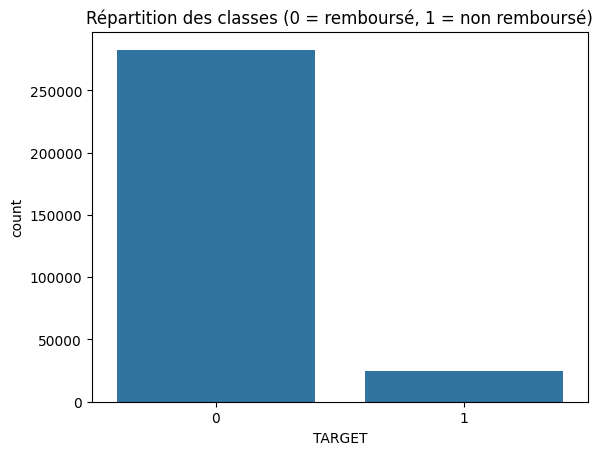

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=raw_data['application_train'], x='TARGET')
plt.title("Répartition des classes (0 = remboursé, 1 = non remboursé)")
plt.show()

print(raw_data['application_train']['TARGET'].value_counts(normalize=True))

Comme il est indiqué qu'on le peut dans l'intitulé du projet, je vais fortement m'inspirer du Kaggle mis à disposition pour l'analyse exploratoire et le feature engineering. Je vais ajouter mes propres commentaires et autres visualisations supplémentaires que je trouve pertinentes pour répondre à la problématique métier et comprendre les données. De plus, avant de me servir de ces notebooks Kaggle, j'ai moi même analysé chaque df et chaque colonne pour comprendre exactement de quoi il retourne. Je vais ensuite créer mes propres modèles de machine learning, optimiser les hyperparamètres à ma façon et choisir les métriques d'évaluation que je trouve les plus pertinentes.

In [18]:
raw_data['application_train']['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


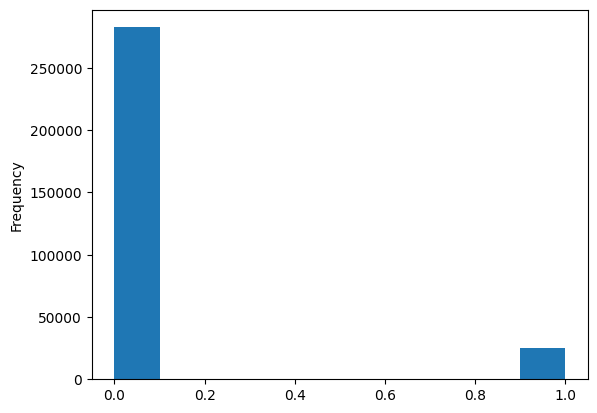

In [19]:
raw_data['application_train']['TARGET'].astype(int).plot.hist();

In [20]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [21]:
missing_values_table(raw_data['application_train'])

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


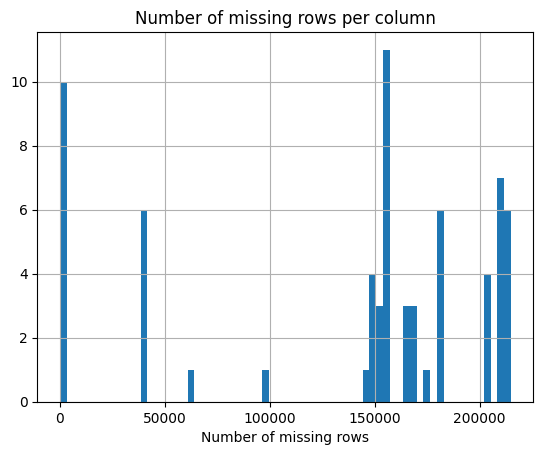

In [22]:
#We now have to deal with columns that contains null values
missing = raw_data['application_train'].isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

#Lets visualize the number of null values in all the columns
missing.hist(bins=len(missing))
plt.title('Number of missing rows per column')
plt.xlabel('Number of missing rows')
plt.show()

In [23]:
# Number of unique classes in each object column
raw_data['application_train'].select_dtypes('object').apply(pd.Series.nunique, axis = 0)

,0
NAME_CONTRACT_TYPE,2
CODE_GENDER,3
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
NAME_TYPE_SUITE,7
NAME_INCOME_TYPE,8
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
OCCUPATION_TYPE,18


In [24]:
# Number of each type of column
raw_data['application_train'].dtypes.value_counts()

,count
float64,65
int64,41
object,16


In [25]:
# Sauvegarde de la variable cible avant alignement
etiquettes_cible = raw_data['application_train']['TARGET']

# Alignement des colonnes entre les deux datasets (on garde uniquement les colonnes communes)
application_train, application_test = raw_data['application_train'].align(raw_data['application_test'], join='inner', axis=1)

# Réintégration de la variable cible dans le jeu d'entraînement
application_train['TARGET'] = etiquettes_cible

# Affichage des dimensions finales
print("Shape du jeu d'entraînement :", application_train.shape)
print("Shape du jeu de test :", application_test.shape)

Shape du jeu d'entraînement : (307511, 122)
Shape du jeu de test : (48744, 121)


In [26]:
(application_train['DAYS_BIRTH'] / -365).describe()

,DAYS_BIRTH
count,307511.000000
mean,43.936973
std,11.956133
min,20.517808
25%,34.008219
50%,43.150685
75%,53.923288
max,69.120548


In [27]:
application_train['DAYS_EMPLOYED'].describe()

,DAYS_EMPLOYED
count,307511.000000
mean,63815.045904
std,141275.766519
min,-17912.000000
25%,-2760.000000
50%,-1213.000000
75%,-289.000000
max,365243.000000


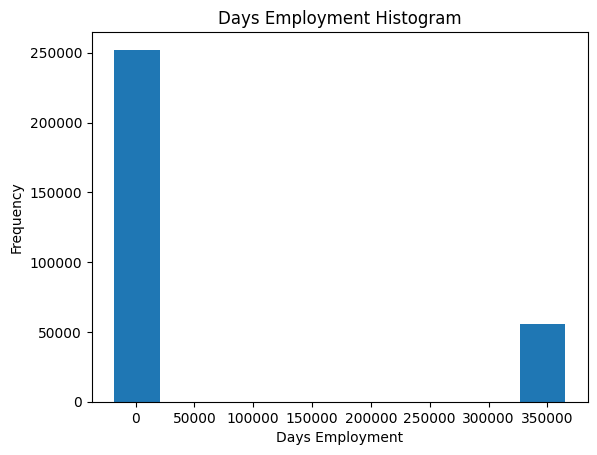

In [28]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [29]:
# Séparation entre les valeurs normales et les valeurs anormales de la variable DAYS_EMPLOYED
valeurs_anormales = application_train[application_train['DAYS_EMPLOYED'] == 365243]
valeurs_normales = application_train[application_train['DAYS_EMPLOYED'] != 365243]

# Affichage du taux de défaut pour les deux groupes
print("Les clients sans anomalie de durée d'emploi ont un taux de défaut de : %0.2f%%" %
      (100 * valeurs_normales['TARGET'].mean()))
print("Les clients avec anomalie (365243 jours) ont un taux de défaut de : %0.2f%%" %
      (100 * valeurs_anormales['TARGET'].mean()))
print("Il y a %d lignes avec une valeur anormale (365243 jours) dans DAYS_EMPLOYED." % len(valeurs_anormales))

Les clients sans anomalie de durée d'emploi ont un taux de défaut de : 8.66%
Les clients avec anomalie (365243 jours) ont un taux de défaut de : 5.40%
Il y a 55374 lignes avec une valeur anormale (365243 jours) dans DAYS_EMPLOYED.


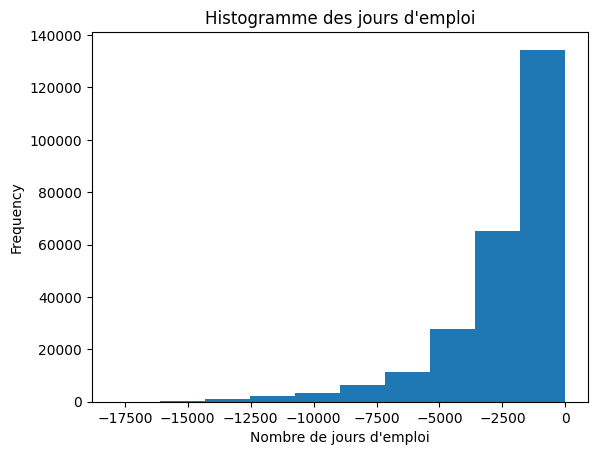

In [30]:
import numpy as np

# Création d'une colonne indiquant si la valeur de DAYS_EMPLOYED est anormale (365243 jours)
application_train['DAYS_EMPLOYED_ANOM'] = application_train['DAYS_EMPLOYED'] == 365243

# Remplacement des valeurs anormales par NaN
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# Affichage d'un histogramme des jours d'emploi (hors valeurs aberrantes)
application_train['DAYS_EMPLOYED'].plot.hist(title='Histogramme des jours d\'emploi')
plt.xlabel('Nombre de jours d\'emploi')
plt.show()

In [31]:
# Création d'une colonne pour indiquer les valeurs anormales dans le test set
application_test['DAYS_EMPLOYED_ANOM'] = application_test['DAYS_EMPLOYED'] == 365243

# Remplacement des valeurs anormales par NaN
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# Affichage du nombre d'anomalies détectées
print("Il y a %d anomalies (valeurs à 365243 jours) dans les données de test sur un total de %d entrées." %
      (application_test['DAYS_EMPLOYED_ANOM'].sum(), len(application_test)))

Il y a 9274 anomalies (valeurs à 365243 jours) dans les données de test sur un total de 48744 entrées.


/tmp/ipython-input-4107985150.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


In [32]:
# Transformation de la variable DAYS_BIRTH en nombre de jours positifs (absolu)
application_train['DAYS_BIRTH'] = application_train['DAYS_BIRTH'].abs()

# Calcul de la corrélation entre l'âge (en jours) et le défaut de crédit
correlation = application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

# Affichage du résultat
print("Corrélation entre l'âge du client (en jours) et la variable cible TARGET :", round(correlation, 3))

Corrélation entre l'âge du client (en jours) et la variable cible TARGET : -0.078


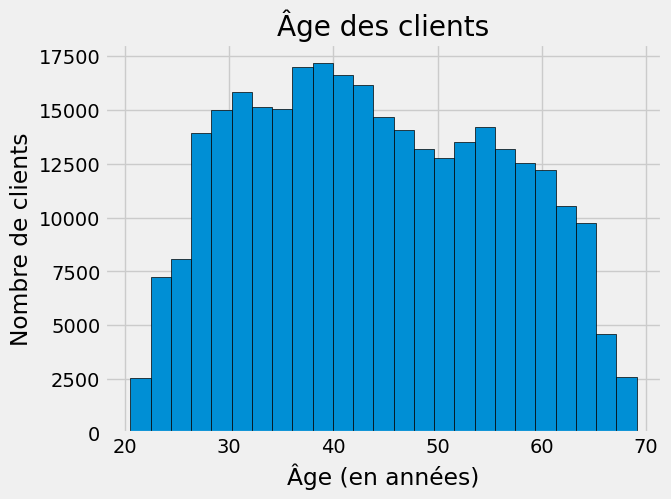

In [33]:
# Définit le style graphique
plt.style.use('fivethirtyeight')

# Trace l'histogramme de l'âge des clients (en années)
plt.hist(application_train['DAYS_BIRTH'] / 365, edgecolor='k', bins=25)
plt.title("Âge des clients")
plt.xlabel("Âge (en années)")
plt.ylabel("Nombre de clients")
plt.show()

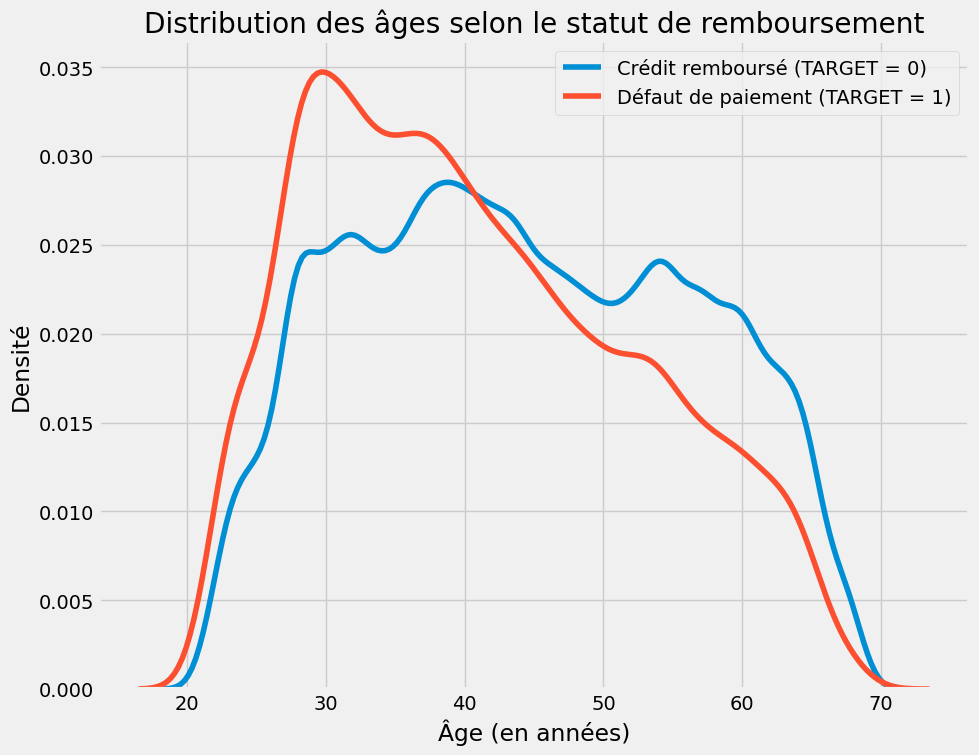

In [34]:
# On crée une figure avec une taille personnalisée
plt.figure(figsize = (10, 8))

# Tracé KDE des clients qui ont remboursé leur prêt (TARGET = 0)
sns.kdeplot(
    application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365,
    label = 'Crédit remboursé (TARGET = 0)'
)

# Tracé KDE des clients qui n'ont pas remboursé leur prêt (TARGET = 1)
sns.kdeplot(
    application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365,
    label = 'Défaut de paiement (TARGET = 1)'
)

# Titres et étiquettes
plt.xlabel('Âge (en années)')
plt.ylabel('Densité')
plt.title('Distribution des âges selon le statut de remboursement')
plt.legend()
plt.show()

Ce graphique KDE (Kernel Density Estimation) montre comment l’âge des clients est corrélé au risque de défaut de paiement.

In [35]:
# Extrait les colonnes d'âge et de TARGET dans un nouveau DataFrame
age_data = application_train[['TARGET', 'DAYS_BIRTH']].copy()

# Converti l'âge en années (valeurs absolues car les jours sont négatifs)
age_data['AGE_EN_ANNEES'] = abs(age_data['DAYS_BIRTH']) / 365

# Découpe l'âge en tranches régulières entre 20 et 70 ans (10 intervalles)
age_data['TRANCHE_AGE'] = pd.cut(age_data['AGE_EN_ANNEES'], bins=np.linspace(20, 70, num=11))

# Affiche les 10 premières lignes pour vérification
age_data.head(10)

,TARGET,DAYS_BIRTH,AGE_EN_ANNEES,TRANCHE_AGE
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


/tmp/ipython-input-3687434046.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupes_age = age_data.groupby('TRANCHE_AGE').mean(numeric_only=True)


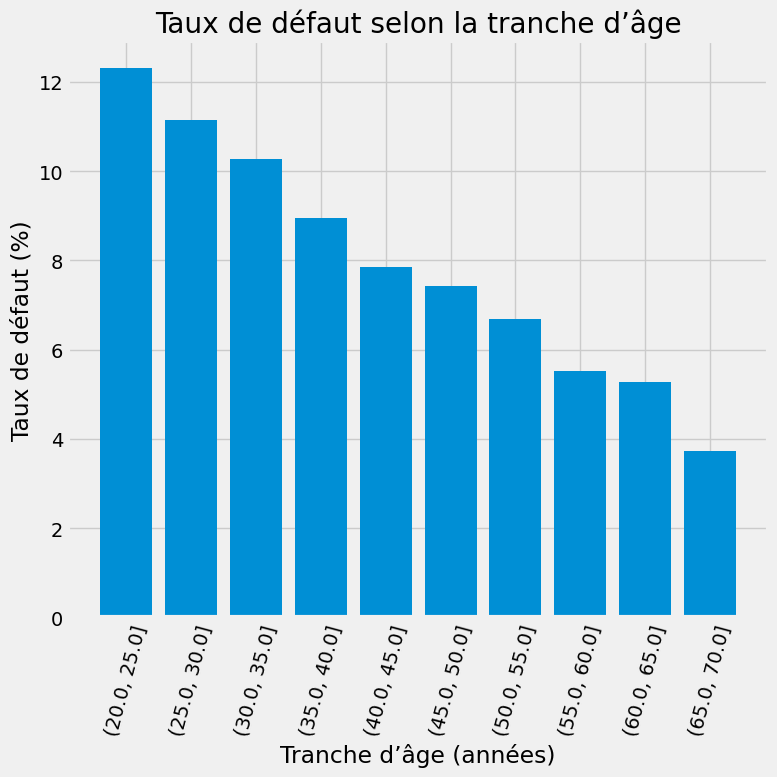

In [36]:
# Calcul du taux de défaut moyen pour chaque tranche d'âge
groupes_age = age_data.groupby('TRANCHE_AGE').mean(numeric_only=True)

# Création de la figure
plt.figure(figsize=(8, 8))

# Tracer un graphique en barres des tranches d'âge vs. taux de défaut (%)
plt.bar(groupes_age.index.astype(str), 100 * groupes_age['TARGET'])

# Ajout des labels et du titre
plt.xticks(rotation=75)
plt.xlabel('Tranche d’âge (années)')
plt.ylabel('Taux de défaut (%)')
plt.title('Taux de défaut selon la tranche d’âge')

# Affichage du graphique
plt.tight_layout()
plt.show()

Comme l'a dit la personne sur Kaggle, on observe une tendance nette : les clients les plus jeunes ont un taux de défaut plus élevé. Le taux de non-remboursement dépasse les 10 % pour les trois tranches d’âge les plus jeunes, alors qu’il descend sous les 5 % pour les tranches les plus âgées.

Cette information peut être utile pour la banque : plutôt que d’exclure les jeunes emprunteurs, il serait judicieux de mettre en place un accompagnement renforcé pour ces profils (ex. : conseils en gestion budgétaire, rappel d’échéances, etc.).

Cela permettrait de limiter les risques de défaut, sans discrimination, en agissant de manière proactive.

In [37]:
# Pour afficher toute la largeur des colonnes sans troncature
pd.set_option('display.max_colwidth', None)

# Affichage des premières lignes pour vérifier la structure
print(raw_data['HomeCredit_columns_description'].head())

# Filtrage des lignes contenant "EXT_SOURCE"
ext_source_desc = raw_data['HomeCredit_columns_description'][
    raw_data['HomeCredit_columns_description']['Row'].str.contains("EXT_SOURCE", na=False)
]

# Affichage avec description complète
print("\nDescriptions complètes des colonnes EXT_SOURCE :")
print(ext_source_desc[['Row', 'Description']])

   Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                                                                                                                                                                   Description  \
0                                                                                                                                                                     ID of loan in our sample   
1  Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)   
2              

Comme l'a indiqué l'utilisateur du projet Kaggle mis à disposition, les trois variables EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3 sont celles qui présentent les corrélations négatives les plus fortes avec la variable cible TARGET, c’est-à-dire la probabilité qu’un client ne rembourse pas son crédit.

D’après la documentation fournie (HomeCredit_columns_description.csv), ces variables représentent un score normalisé provenant de sources de données externes ("Normalized score from external data source"). Même si la signification exacte de ces scores n’est pas détaillée, on peut supposer qu’il s’agit de notes de solvabilité calculées à partir de sources tierces, comme des agences de crédit ou des historiques de paiement agrégés.

Autrement dit, ce sont probablement des indicateurs synthétiques (entre 0 et 1) de fiabilité financière, utilisés pour évaluer le risque de défaut de paiement d’un client selon des critères externes à la base de données principale.

Une valeur élevée de ces scores EXT_SOURCE semble associée à un faible risque de défaut, ce qui expliquerait leur corrélation négative avec TARGET (0 = remboursé, 1 = défaut de paiement).

In [38]:
# Extrait les variables EXT_SOURCE ainsi que l'âge et la cible
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# Calcul de la matrice de corrélation entre ces variables
correlations_ext = ext_data.corr()

# Affiche la matrice de corrélation
print("Corrélations entre les variables EXT_SOURCE, l'âge et la cible :\n")
print(correlations_ext)

Corrélations entre les variables EXT_SOURCE, l'âge et la cible :

                TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000


Text(0.5, 1.0, 'Heatmap des corrélations entre EXT_SOURCE, âge et cible')

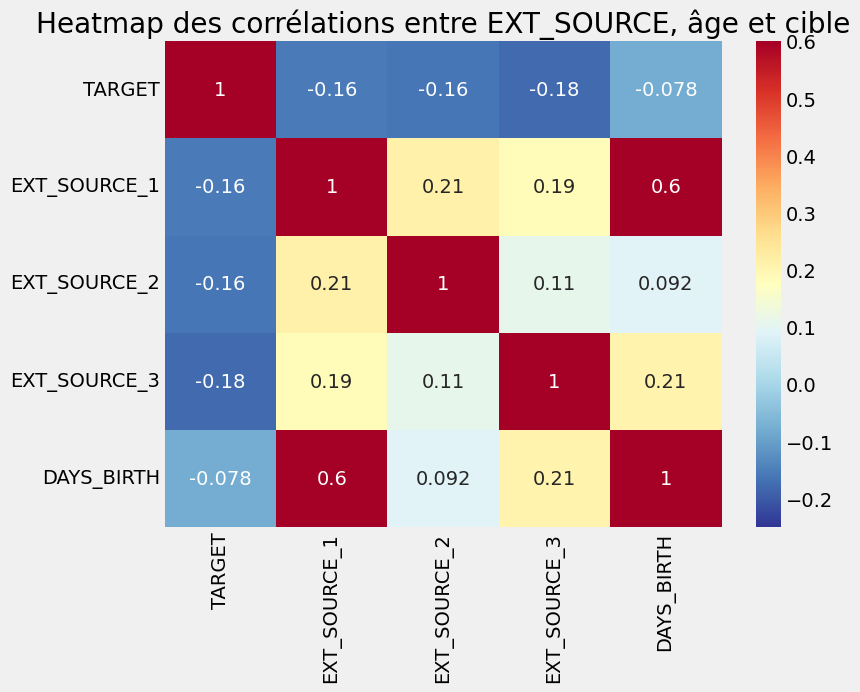

In [39]:
# Crée une figure avec une taille personnalisée
plt.figure(figsize=(8, 6))

# Affiche une carte thermique des corrélations entre EXT_SOURCE, l'âge et la cible
# - cmap : la palette de couleurs utilisée (du rouge au bleu)
# - vmin et vmax : les bornes des valeurs de corrélation à afficher
# - annot = True : affiche les valeurs dans chaque case
sns.heatmap(correlations_ext, cmap=plt.cm.RdYlBu_r, vmin=-0.25, vmax=0.6, annot=True)

# Ajoute un titre au graphique
plt.title("Heatmap des corrélations entre EXT_SOURCE, âge et cible")

Les trois variables EXT_SOURCE présentent toutes une corrélation négative avec la variable cible TARGET. Cela signifie que plus la valeur d'une variable EXT_SOURCE est élevée, plus le client a de chances de rembourser son prêt. Autrement dit, un score externe élevé est généralement un bon indicateur de fiabilité.

Grâce au travail de la personne du projet Kaggle, on observe également que la variable DAYS_BIRTH est positivement corrélée avec EXT_SOURCE_1, ce qui peut suggérer que l’âge du client est l’un des éléments pris en compte dans le calcul de ce score externe.

Ensuite, nous allons examiner la distribution de chacune de ces variables EXT_SOURCE, en les colorant selon la valeur de la cible (TARGET). Cela nous permettra de visualiser plus concrètement l’influence de chaque score externe sur le risque de défaut de paiement.

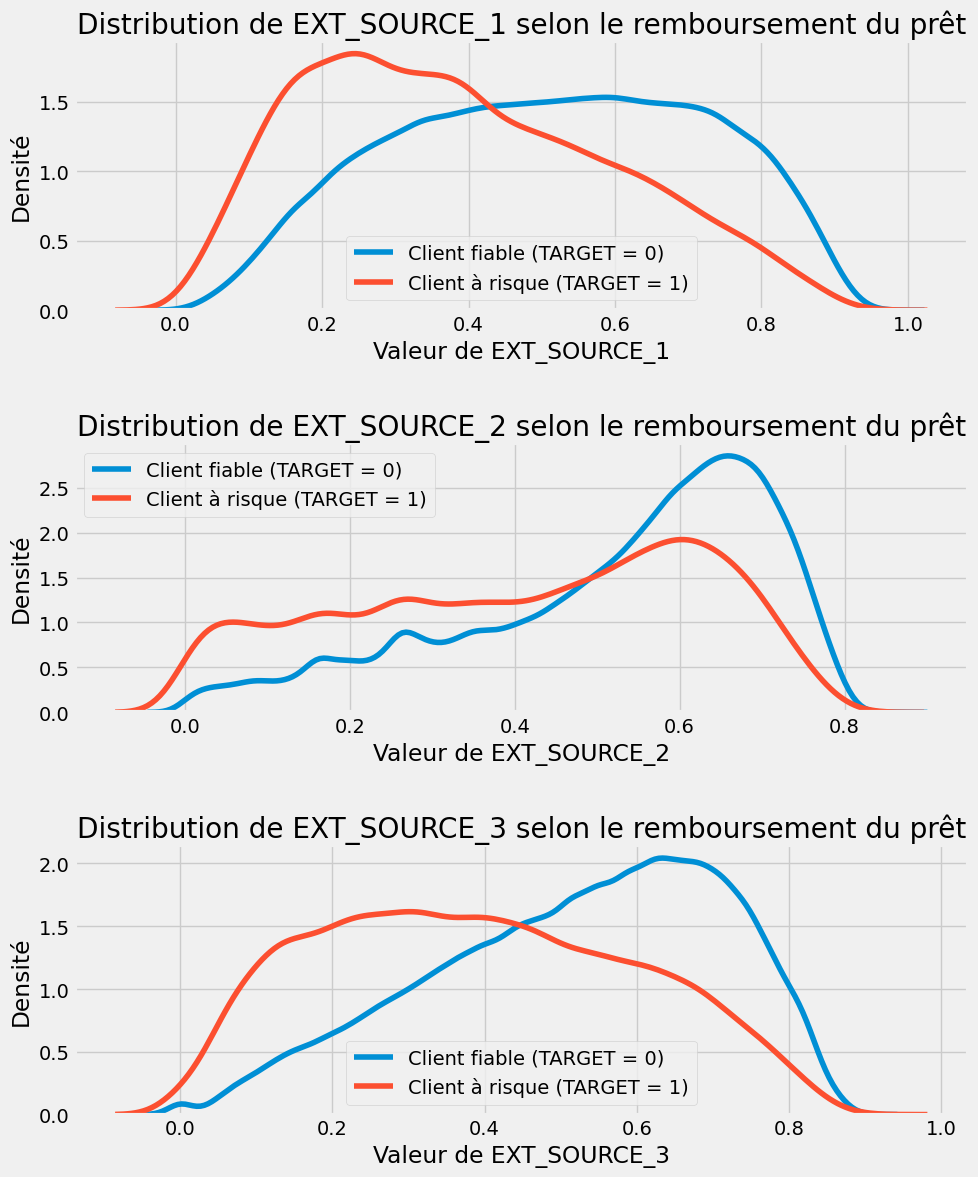

In [40]:
# Crée une figure de taille verticale adaptée à 3 graphiques
plt.figure(figsize=(10, 12))

# Boucle sur les 3 variables EXT_SOURCE
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # Crée un sous-graphique (subplot) par EXT_SOURCE
    plt.subplot(3, 1, i + 1)

    # Trace la distribution des scores pour les clients qui ont remboursé (TARGET = 0)
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label='Client fiable (TARGET = 0)')

    # Trace la distribution des scores pour les clients qui n'ont pas remboursé (TARGET = 1)
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label='Client à risque (TARGET = 1)')

    # Ajoute les titres et légendes
    plt.title(f'Distribution de {source} selon le remboursement du prêt')
    plt.xlabel(f'Valeur de {source}')
    plt.ylabel('Densité')
    plt.legend()

# Ajustement automatique de l'espacement vertical entre les sous-graphes
plt.tight_layout(h_pad=2.5)

Parmi les trois variables EXT_SOURCE, c’est EXT_SOURCE_3 qui montre la plus grande différence de distribution entre les clients qui remboursent leur prêt et ceux qui ne le font pas. Cela suggère qu’il existe une relation notable entre ce score et la probabilité de remboursement.

Même si la corrélation reste faible d’un point de vue statistique, ces variables contiennent tout de même des informations utiles que les modèles de machine learning peuvent exploiter pour mieux prédire le risque de défaut d’un client. Ce sont des signaux faibles, mais potentiellement précieux une fois combinés avec d'autres données.

Après avoir fait ma propre première analyse des df puis avoir repris le notebook Kaggle mis à disposition pour la suite de l'analyse exploratoire et prétraitement des données, avoir ajouté des visualisations supplémentaires et commentaires, je vais maintenant procéder au feature engineering notamment à l'aide d'un autre notebook Kaggle mis à disposition en expliquant la démarche. Puis, il me restera à créer mes propres modèles de machine learning qui sont au coeur du projet et chercherai à optimiser au mieux leurs hyperparamètres et choisirai les métriques d'évaluation que j'estime les plus pertinentes.

In [41]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    """Contexte manager pour mesurer le temps d'exécution"""
    t0 = time.time()
    yield
    print("{} - terminé en {:.0f}s".format(title, time.time() - t0))

def safe_div(a, b, fill_value=0):
    """Division sécurisée qui gère les divisions par zéro et les infinis"""
    result = np.divide(a, b, out=np.zeros_like(a, dtype=float), where=(b != 0))
    result = np.where(np.isinf(result), fill_value, result)
    result = np.where(np.isnan(result), fill_value, result)
    return result

def one_hot_encoder(df, nan_as_category=True):
    """Applique un encodage One-Hot aux variables catégorielles"""
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def remove_constant_columns(df, threshold=0.98):
    """
    Supprime les colonnes avec une seule valeur unique ou trop peu de variance

    Paramètres:
    - df: DataFrame
    - threshold: Si une valeur représente plus de ce % des données, supprime la colonne
    """
    cols_to_drop = []

    for col in df.columns:
        if col in ['SK_ID_CURR', 'TARGET']:
            continue

        # Vérifie si une seule valeur unique
        if df[col].nunique(dropna=False) <= 1:
            cols_to_drop.append(col)
            continue

        # Vérifie si une valeur domine (>98% des données)
        value_counts = df[col].value_counts(dropna=False, normalize=True)
        if len(value_counts) > 0 and value_counts.iloc[0] > threshold:
            cols_to_drop.append(col)

    if cols_to_drop:
        print(f"Suppression de {len(cols_to_drop)} colonnes constantes/quasi-constantes")
        df.drop(columns=cols_to_drop, inplace=True)

    return df

def application_train_preprocessing(num_rows=None, nan_as_category=False):
    """Préprocesse application_train.csv avec features avancées"""

    df = pd.read_csv(DATA_DIR / 'application_train.csv', nrows=num_rows)
    print("Échantillons d'entraînement: {}".format(len(df)))

    # Supprime les valeurs aberrantes
    df = df[df['CODE_GENDER'] != 'XNA']

    # Variables binaires
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # One-Hot encoding
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Gestion des valeurs aberrantes DAYS_EMPLOYED
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_EMPLOYED_ANOM'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)

    # ============== FEATURES DE BASE (SAFE) ==============

    # Ratios de revenus et crédit
    df['INCOME_CREDIT_PERC'] = safe_div(df['AMT_INCOME_TOTAL'], df['AMT_CREDIT'])
    df['INCOME_PER_PERSON'] = safe_div(df['AMT_INCOME_TOTAL'], df['CNT_FAM_MEMBERS'])
    df['ANNUITY_INCOME_PERC'] = safe_div(df['AMT_ANNUITY'], df['AMT_INCOME_TOTAL'])
    df['PAYMENT_RATE'] = safe_div(df['AMT_ANNUITY'], df['AMT_CREDIT'])
    df['CREDIT_TO_ANNUITY_RATIO'] = safe_div(df['AMT_CREDIT'], df['AMT_ANNUITY'])
    df['CREDIT_TO_GOODS_RATIO'] = safe_div(df['AMT_CREDIT'], df['AMT_GOODS_PRICE'])

    # Ratios temporels (en valeur absolue)
    df['DAYS_EMPLOYED_PERC'] = safe_div(df['DAYS_EMPLOYED'], df['DAYS_BIRTH'])
    df['DAYS_EMPLOYED_RATIO'] = safe_div(df['DAYS_EMPLOYED'].abs(), df['DAYS_BIRTH'].abs())
    df['AGE_TO_CREDIT_RATIO'] = safe_div(df['DAYS_BIRTH'].abs(), df['AMT_CREDIT'])
    df['INCOME_PER_AGE'] = safe_div(df['AMT_INCOME_TOTAL'], df['DAYS_BIRTH'].abs() / 365)

    # ============== FEATURES EXTERNES (TRÈS IMPORTANTES) ==============

    # EXT_SOURCE features
    df['EXT_SOURCE_1'].fillna(df['EXT_SOURCE_1'].median(), inplace=True)
    df['EXT_SOURCE_2'].fillna(df['EXT_SOURCE_2'].median(), inplace=True)
    df['EXT_SOURCE_3'].fillna(df['EXT_SOURCE_3'].median(), inplace=True)

    df['EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['EXT_SOURCES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['EXT_SOURCES_MIN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1)
    df['EXT_SOURCES_MAX'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1)
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df['EXT_SOURCE_1'] * 2 + df['EXT_SOURCE_2'] * 3 + df['EXT_SOURCE_3'] * 4
    df['EXT_SOURCES_RANGE'] = df['EXT_SOURCES_MAX'] - df['EXT_SOURCES_MIN']

    # Interactions EXT_SOURCE avec autres variables
    df['EXT_SOURCE_1_X_CREDIT'] = df['EXT_SOURCE_1'] * df['AMT_CREDIT']
    df['EXT_SOURCE_2_X_CREDIT'] = df['EXT_SOURCE_2'] * df['AMT_CREDIT']
    df['EXT_SOURCE_3_X_CREDIT'] = df['EXT_SOURCE_3'] * df['AMT_CREDIT']

    # ============== FEATURES DE DOCUMENTS ==============

    doc_flags = [col for col in df.columns if col.startswith('FLAG_DOCUMENT_')]
    df['DOCUMENT_COUNT'] = df[doc_flags].sum(axis=1)

    # ============== FEATURES DE CONTACT ==============

    contact_flags = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
                     'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']
    df['CONTACT_INFO_COUNT'] = df[contact_flags].sum(axis=1)

    # ============== FEATURES DE RÉGION ==============

    region_cols = [col for col in df.columns if 'REGION' in col and 'RATING' in col]
    if region_cols:
        df['REGION_RATING_MEAN'] = df[region_cols].mean(axis=1)

    # ============== FEATURES D'ENQUÊTE ==============

    enquiry_cols = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
                    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
                    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

    for col in enquiry_cols:
        if col in df.columns:
            df[col].fillna(0, inplace=True)

    df['CREDIT_ENQUIRIES_TOTAL'] = df[enquiry_cols].sum(axis=1)
    df['CREDIT_ENQUIRIES_RECENT'] = df[['AMT_REQ_CREDIT_BUREAU_HOUR',
                                         'AMT_REQ_CREDIT_BUREAU_DAY']].sum(axis=1)

    # ============== SCORE DE STABILITÉ ==============

    df['FINANCIAL_STABILITY_SCORE'] = (
        safe_div(df['AMT_INCOME_TOTAL'], df['AMT_CREDIT']) *
        safe_div(df['DAYS_EMPLOYED'].abs(), df['DAYS_BIRTH'].abs())
    ).clip(0, 10)

    # ============== FEATURES DÉMOGRAPHIQUES ==============

    df['AGE_YEARS'] = (df['DAYS_BIRTH'].abs() / 365).astype(int)
    df['EMPLOYMENT_YEARS'] = (df['DAYS_EMPLOYED'].abs() / 365)
    df['CAR_AGE_RATIO'] = safe_div(df['OWN_CAR_AGE'], df['AGE_YEARS'])

    # ============== NETTOYAGE FINAL ==============

    # Remplace les infinis restants
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Supprime les colonnes constantes
    df = remove_constant_columns(df)

    gc.collect()
    return df

def bureau_and_balance(num_rows=None, nan_as_category=True):
    """Préprocesse bureau.csv et bureau_balance.csv avec features avancées"""

    bureau = pd.read_csv(DATA_DIR / 'bureau.csv', nrows=num_rows)
    bb = pd.read_csv(DATA_DIR / 'bureau_balance.csv', nrows=num_rows)

    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # ============== BUREAU BALANCE AGGREGATIONS ==============

    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size', 'mean', 'std']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']

    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)

    del bb, bb_agg
    gc.collect()

    # ============== FEATURES SUPPLÉMENTAIRES BUREAU ==============

    # Binary features
    bureau['CREDIT_ENDDATE_BINARY'] = (bureau['DAYS_CREDIT_ENDDATE'] > 0).astype(int)
    bureau['DEBT_CREDIT_RATIO'] = safe_div(bureau['AMT_CREDIT_SUM_DEBT'], bureau['AMT_CREDIT_SUM'])
    bureau['OVERDUE_RATIO'] = safe_div(bureau['AMT_CREDIT_SUM_OVERDUE'], bureau['AMT_CREDIT_SUM'])
    bureau['CREDIT_UTILIZATION'] = safe_div(bureau['AMT_CREDIT_SUM_DEBT'], bureau['AMT_CREDIT_SUM_LIMIT'])

    # ============== AGRÉGATIONS NUMÉRIQUES ==============

    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var', 'std'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean', 'std'],
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum', 'std'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum', 'std'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum', 'max'],
        'AMT_ANNUITY': ['max', 'mean', 'std'],
        'CNT_CREDIT_PROLONG': ['sum', 'mean'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'DEBT_CREDIT_RATIO': ['mean', 'max'],
        'OVERDUE_RATIO': ['mean', 'max'],
        'CREDIT_UTILIZATION': ['mean', 'max']
    }

    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Nombre de crédits au bureau
    bureau_agg['BURO_COUNT'] = bureau.groupby('SK_ID_CURR').size()

    # ============== CRÉDITS ACTIFS ==============

    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    if len(active) > 0:
        active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
        active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
        bureau_agg['ACTIVE_COUNT'] = active.groupby('SK_ID_CURR').size()
        del active_agg

    # ============== CRÉDITS FERMÉS ==============

    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    if len(closed) > 0:
        closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
        closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
        bureau_agg['CLOSED_COUNT'] = closed.groupby('SK_ID_CURR').size()
        del closed_agg

    # ============== RATIO ACTIFS/FERMÉS ==============

    bureau_agg['ACTIVE_TO_CLOSED_RATIO'] = safe_div(
        bureau_agg.get('ACTIVE_COUNT', 0),
        bureau_agg.get('CLOSED_COUNT', 0)
    )

    del active, closed, bureau
    gc.collect()

    # Nettoyage
    bureau_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    bureau_agg = remove_constant_columns(bureau_agg)

    return bureau_agg

def previous_applications(num_rows=None, nan_as_category=True):
    """Préprocesse previous_application.csv avec features avancées"""

    prev = pd.read_csv(DATA_DIR / 'previous_application.csv', nrows=num_rows, on_bad_lines='skip')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

    # Gestion des valeurs aberrantes
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

    # ============== FEATURES AVANCÉES ==============

    prev['APP_CREDIT_PERC'] = safe_div(prev['AMT_APPLICATION'], prev['AMT_CREDIT'])
    prev['CREDIT_TO_ANNUITY_RATIO'] = safe_div(prev['AMT_CREDIT'], prev['AMT_ANNUITY'])
    prev['DOWN_PAYMENT_PERC'] = safe_div(prev['AMT_DOWN_PAYMENT'], prev['AMT_APPLICATION'])
    prev['CREDIT_TO_GOODS_RATIO'] = safe_div(prev['AMT_CREDIT'], prev['AMT_GOODS_PRICE'])
    prev['INTEREST_RATE'] = safe_div(prev['AMT_ANNUITY'] * prev['CNT_PAYMENT'], prev['AMT_CREDIT']) - 1

    # Features temporelles
    prev['DAYS_DECISION_TO_BIRTH'] = prev['DAYS_DECISION'] - prev['DAYS_BIRTH'] if 'DAYS_BIRTH' in prev.columns else 0

    # ============== AGRÉGATIONS ==============

    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean', 'std'],
        'AMT_APPLICATION': ['min', 'max', 'mean', 'std'],
        'AMT_CREDIT': ['min', 'max', 'mean', 'sum', 'std'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'std'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean', 'std'],
        'CNT_PAYMENT': ['mean', 'sum', 'max'],
        'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
        'DOWN_PAYMENT_PERC': ['mean', 'max'],
        'CREDIT_TO_GOODS_RATIO': ['mean', 'max'],
        'INTEREST_RATE': ['mean', 'max', 'min']
    }

    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    prev_agg['PREV_COUNT'] = prev.groupby('SK_ID_CURR').size()

    # ============== DEMANDES APPROUVÉES ==============

    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    if len(approved) > 0:
        approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
        approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
        prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
        prev_agg['APPROVED_COUNT'] = approved.groupby('SK_ID_CURR').size()
        del approved_agg

    # ============== DEMANDES REFUSÉES ==============

    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    if len(refused) > 0:
        refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
        refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
        prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
        prev_agg['REFUSED_COUNT'] = refused.groupby('SK_ID_CURR').size()
        del refused_agg

    # ============== TAUX D'APPROBATION ==============

    prev_agg['APPROVAL_RATE'] = safe_div(
        prev_agg.get('APPROVED_COUNT', 0),
        prev_agg.get('PREV_COUNT', 1)
    )

    del refused, approved, prev
    gc.collect()

    prev_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    prev_agg = remove_constant_columns(prev_agg)

    return prev_agg

def pos_cash(num_rows=None, nan_as_category=True):
    """Préprocesse POS_CASH_balance.csv avec features avancées"""

    pos = pd.read_csv(DATA_DIR / 'POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)

    # ============== FEATURES SUPPLÉMENTAIRES ==============

    pos['IS_DPD'] = (pos['SK_DPD'] > 0).astype(int)
    pos['IS_DPD_DEF'] = (pos['SK_DPD_DEF'] > 0).astype(int)

    # ============== AGRÉGATIONS ==============

    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size', 'min', 'std'],
        'SK_DPD': ['max', 'mean', 'sum', 'std'],
        'SK_DPD_DEF': ['max', 'mean', 'sum'],
        'IS_DPD': ['mean', 'sum'],
        'IS_DPD_DEF': ['mean', 'sum']
    }

    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

    # Taux de retard
    pos_agg['POS_DPD_RATE'] = safe_div(pos_agg['POS_IS_DPD_SUM'], pos_agg['POS_COUNT'])

    del pos
    gc.collect()

    pos_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    pos_agg = remove_constant_columns(pos_agg)

    return pos_agg

def installments_payments(num_rows=None, nan_as_category=True):
    """Préprocesse installments_payments.csv avec features avancées"""

    ins = pd.read_csv(DATA_DIR / 'installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)

    # ============== FEATURES AVANCÉES ==============

    ins['PAYMENT_PERC'] = safe_div(ins['AMT_PAYMENT'], ins['AMT_INSTALMENT'])
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    ins['PAYMENT_RATIO'] = safe_div(ins['AMT_PAYMENT'], ins['AMT_INSTALMENT'])

    # Jours de retard
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    # Binary features
    ins['IS_LATE'] = (ins['DPD'] > 0).astype(int)
    ins['IS_EARLY'] = (ins['DBD'] > 0).astype(int)
    ins['PAID_OVER'] = (ins['AMT_PAYMENT'] > ins['AMT_INSTALMENT']).astype(int)
    ins['PAID_UNDER'] = (ins['AMT_PAYMENT'] < ins['AMT_INSTALMENT']).astype(int)

    # ============== AGRÉGATIONS ==============

    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique', 'max'],
        'DPD': ['max', 'mean', 'sum', 'std'],
        'DBD': ['max', 'mean', 'sum', 'std'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var', 'std'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var', 'std'],
        'PAYMENT_RATIO': ['mean', 'std'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum', 'std'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum', 'std'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum'],
        'IS_LATE': ['mean', 'sum'],
        'IS_EARLY': ['mean', 'sum'],
        'PAID_OVER': ['mean', 'sum'],
        'PAID_UNDER': ['mean', 'sum']
    }

    for cat in cat_cols:
        aggregations[cat] = ['mean']

    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    # Taux de retard
    ins_agg['INSTAL_LATE_RATE'] = safe_div(ins_agg['INSTAL_IS_LATE_SUM'], ins_agg['INSTAL_COUNT'])
    ins_agg['INSTAL_PAYMENT_SUCCESS_RATE'] = 1 - safe_div(ins_agg['INSTAL_PAID_UNDER_SUM'], ins_agg['INSTAL_COUNT'])

    del ins
    gc.collect()

    ins_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    ins_agg = remove_constant_columns(ins_agg)

    return ins_agg

def credit_card_balance(num_rows=None, nan_as_category=True):
    """Préprocesse credit_card_balance.csv avec features avancées"""

    cc = pd.read_csv(DATA_DIR / 'credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)

    # ============== FEATURES AVANCÉES ==============

    cc['BALANCE_LIMIT_RATIO'] = safe_div(cc['AMT_BALANCE'], cc['AMT_CREDIT_LIMIT_ACTUAL'])
    cc['MIN_PAYMENT_RATIO'] = safe_div(cc['AMT_PAYMENT_CURRENT'], cc['AMT_INST_MIN_REGULARITY'])
    cc['PAYMENT_DIV_MIN'] = safe_div(cc['AMT_PAYMENT_CURRENT'], cc['AMT_INST_MIN_REGULARITY'])
    cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    cc['DRAWING_LIMIT_RATIO'] = safe_div(cc['AMT_DRAWINGS_ATM_CURRENT'] + cc['AMT_DRAWINGS_CURRENT'] +
                                         cc['AMT_DRAWINGS_POS_CURRENT'], cc['AMT_CREDIT_LIMIT_ACTUAL'])

    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)

    # ============== AGRÉGATIONS ==============

    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var', 'std'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

    # Taux de retard
    if 'CC_LATE_PAYMENT_SUM' in cc_agg.columns:
        cc_agg['CC_LATE_PAYMENT_RATE'] = safe_div(cc_agg['CC_LATE_PAYMENT_SUM'], cc_agg['CC_COUNT'])

    del cc
    gc.collect()

    cc_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    cc_agg = remove_constant_columns(cc_agg)

    return cc_agg

def prepare_data_for_modeling(df):
    """Prépare les données pour la modélisation"""
    feats = [f for f in df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
    X = df[feats]
    y = df['TARGET']
    return X, y, feats

def display_importances(feature_importance_df_):
    """Affiche un graphique des features les plus importantes"""
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Importance des Features (moyenne sur les folds)')
    plt.tight_layout()
    plt.savefig('feature_importances.png')
    plt.show()

def add_cross_dataset_features(df):
    """
    Ajoute des features cross-dataset (interactions entre différentes sources)
    À appeler APRÈS avoir joint tous les datasets
    """
    print("\nCréation de features cross-dataset...")

    # Ratios Bureau / Application
    if 'BURO_AMT_CREDIT_SUM_MEAN' in df.columns:
        df['BURO_TO_APP_CREDIT_RATIO'] = safe_div(df['BURO_AMT_CREDIT_SUM_MEAN'], df['AMT_CREDIT'])
        df['BURO_TO_APP_DEBT_RATIO'] = safe_div(df['BURO_AMT_CREDIT_SUM_DEBT_MEAN'], df['AMT_CREDIT'])

    # Ratios Previous / Application
    if 'PREV_AMT_CREDIT_MEAN' in df.columns:
        df['PREV_TO_APP_CREDIT_RATIO'] = safe_div(df['PREV_AMT_CREDIT_MEAN'], df['AMT_CREDIT'])
        df['PREV_TO_APP_ANNUITY_RATIO'] = safe_div(df['PREV_AMT_ANNUITY_MEAN'], df['AMT_ANNUITY'])

    # Score composite de risque
    risk_score = 0
    if 'INSTAL_LATE_RATE' in df.columns:
        risk_score += df['INSTAL_LATE_RATE'].fillna(0) * 0.3
    if 'POS_DPD_RATE' in df.columns:
        risk_score += df['POS_DPD_RATE'].fillna(0) * 0.3
    if 'BURO_CREDIT_DAY_OVERDUE_MEAN' in df.columns:
        risk_score += (df['BURO_CREDIT_DAY_OVERDUE_MEAN'].fillna(0) / 365) * 0.4

    df['COMPOSITE_RISK_SCORE'] = risk_score.clip(0, 1)

    # Score de comportement de paiement
    if 'INSTAL_PAYMENT_SUCCESS_RATE' in df.columns and 'CC_LATE_PAYMENT_RATE' in df.columns:
        df['PAYMENT_BEHAVIOR_SCORE'] = (
            df['INSTAL_PAYMENT_SUCCESS_RATE'].fillna(0.5) * 0.5 +
            (1 - df['CC_LATE_PAYMENT_RATE'].fillna(0.5)) * 0.5
        )

    # Expérience crédit totale
    experience_score = 0
    if 'BURO_COUNT' in df.columns:
        experience_score += df['BURO_COUNT'].fillna(0) / 10
    if 'PREV_COUNT' in df.columns:
        experience_score += df['PREV_COUNT'].fillna(0) / 10

    df['CREDIT_EXPERIENCE_SCORE'] = experience_score.clip(0, 2)

    print(f"Features cross-dataset créées : {['BURO_TO_APP_CREDIT_RATIO', 'COMPOSITE_RISK_SCORE', 'PAYMENT_BEHAVIOR_SCORE', 'CREDIT_EXPERIENCE_SCORE']}")

    return df

def main(debug=False):
    """Fonction principale qui orchestre tout le preprocessing"""

    num_rows = 10000 if debug else None

    print("=" * 60)
    print("DÉBUT DU PREPROCESSING OPTIMISÉ - HOME CREDIT")
    print("=" * 60)

    # Application train
    df = application_train_preprocessing(num_rows)
    print(f"\n✓ Dataset principal: {df.shape}")

    # Bureau
    with timer("Traitement de bureau et bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print(f"✓ Bureau: {bureau.shape}")
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()

    # Previous applications
    with timer("Traitement des demandes précédentes"):
        prev = previous_applications(num_rows)
        print(f"✓ Previous applications: {prev.shape}")
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()

    # POS-CASH
    with timer("Traitement des soldes POS-CASH"):
        pos = pos_cash(num_rows)
        print(f"✓ POS-CASH: {pos.shape}")
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()

    # Installments
    with timer("Traitement des paiements d'échéances"):
        ins = installments_payments(num_rows)
        print(f"✓ Installments: {ins.shape}")
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()

    # Credit card
    with timer("Traitement des cartes de crédit"):
        cc = credit_card_balance(num_rows)
        print(f"✓ Credit cards: {cc.shape}")
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    # Features cross-dataset
    with timer("Création des features cross-dataset"):
        df = add_cross_dataset_features(df)

    # Nettoyage final
    print("\nNettoyage final...")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = remove_constant_columns(df, threshold=0.98)

    # Statistiques finales
    print("\n" + "=" * 60)
    print("PREPROCESSING TERMINÉ AVEC SUCCÈS")
    print("=" * 60)
    print(f"✓ Dataset final: {df.shape}")
    print(f"✓ Nombre de features: {df.shape[1] - 2}")  # -2 pour TARGET et SK_ID_CURR
    print(f"✓ Valeurs manquantes: {df.isnull().sum().sum():,}")
    print(f"✓ Valeurs infinies: {np.isinf(df.select_dtypes(include=[np.number])).sum().sum()}")
    print(f"\n✓ Distribution de la target:")
    print(df['TARGET'].value_counts())
    print(f"\n✓ Taux de défaut: {df['TARGET'].mean():.2%}")

    return df

# Exemple d'utilisation
if __name__ == "__main__":
    # Configuration du chemin des données
    from pathlib import Path
    DATA_DIR = Path('./data')  # Modifie selon ton chemin

    # Lancement du preprocessing
    df = main(debug=False)

    # Préparation pour la modélisation
    X, y, feature_names = prepare_data_for_modeling(df)

    print(f"\n{'=' * 60}")
    print("DONNÉES PRÊTES POUR LA MODÉLISATION")
    print(f"{'=' * 60}")
    print(f"✓ Features (X): {X.shape}")
    print(f"✓ Target (y): {y.shape}")
    print(f"✓ Nombre total de features: {len(feature_names)}")
    print(f"\n✓ Exemples de features créées:")
    feature_examples = [f for f in feature_names if any(keyword in f for keyword in
                       ['EXT_SOURCE', 'RISK', 'RATIO', 'CROSS', 'BEHAVIOR'])][:10]
    for feat in feature_examples:
        print(f"  - {feat}")

    # Sauvegarde optionnelle
    # df.to_csv('processed_data.csv', index=False)
    # print("\n✓ Données sauvegardées dans 'processed_data.csv'")

DÉBUT DU PREPROCESSING OPTIMISÉ - HOME CREDIT
Échantillons d'entraînement: 307511
Suppression de 103 colonnes constantes/quasi-constantes

✓ Dataset principal: (307507, 169)
Suppression de 27 colonnes constantes/quasi-constantes
✓ Bureau: (305811, 147)
Traitement de bureau et bureau_balance - terminé en 31s


/tmp/ipython-input-3760789891.py:328: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prev_agg['PREV_COUNT'] = prev.groupby('SK_ID_CURR').size()


Suppression de 73 colonnes constantes/quasi-constantes
✓ Previous applications: (338857, 228)
Traitement des demandes précédentes - terminé en 41s
Suppression de 7 colonnes constantes/quasi-constantes
✓ POS-CASH: (337252, 21)
Traitement des soldes POS-CASH - terminé en 20s
✓ Installments: (339587, 45)
Traitement des paiements d'échéances - terminé en 36s
Suppression de 38 colonnes constantes/quasi-constantes
✓ Credit cards: (103558, 162)
Traitement des cartes de crédit - terminé en 28s

Création de features cross-dataset...
Features cross-dataset créées : ['BURO_TO_APP_CREDIT_RATIO', 'COMPOSITE_RISK_SCORE', 'PAYMENT_BEHAVIOR_SCORE', 'CREDIT_EXPERIENCE_SCORE']
Création des features cross-dataset - terminé en 0s

Nettoyage final...

PREPROCESSING TERMINÉ AVEC SUCCÈS
✓ Dataset final: (307507, 779)
✓ Nombre de features: 777
✓ Valeurs manquantes: 76,578,106
✓ Valeurs infinies: 0

✓ Distribution de la target:
TARGET
0    282682
1     24825
Name: count, dtype: int64

✓ Taux de défaut: 8.07%



AGE_TO_CREDIT_RATIO = abs(DAYS_BIRTH) / AMT_CREDIT

Que fait ce calcul ? Il rapproche l’âge du client (exprimé en jours) du montant du crédit demandé.

DAYS_BIRTH est négatif dans le dataset (ex : -12000), donc on prend sa valeur absolue (abs) pour avoir un âge positif.

On divise cet âge en jours par le montant du crédit (AMT_CREDIT), ce qui donne une espèce de "coût du crédit par jour de vie".

Que mesure ce ratio ? Il donne une idée indirecte de la prudence ou de la maturité financière du client :

🔹 Valeur élevée → la personne est plutôt âgée et/ou demande un petit crédit → peut-être plus prudente.

🔸 Valeur faible → une personne plus jeune et/ou demandant un gros crédit → peut-être plus risquée.

Pourquoi c’est utile pour le modèle ? Parce que ce ratio peut capturer une interaction implicite entre l'âge et le montant demandé, que ni l'un ni l'autre ne capture seul. Et comme c’est un ratio, il permet de mieux généraliser les comportements dans les modèles.

La "seed" (graine aléatoire) comme `RANDOM_STATE = 42` permet de rendre les opérations "aléatoires" de l'ordinateur (comme séparer les données) reproductibles. Si on exécute le code avec la même seed, on obtient toujours les mêmes résultats, ce qui est utile pour vérifier et partager notre travail.

In [43]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.2/738.2 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/7

In [44]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import mlflow
import mlflow.sklearn
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION GLOBALE
# ============================================================================

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuration MLflow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("credit_scoring_home_credit")

# ============================================================================
# CHARGEMENT DES DONNÉES PREPROCESSÉES
# ============================================================================

print("=" * 60)
print("CHARGEMENT DES DONNÉES")
print("=" * 60)

# 'df' en mémoire après le feature engineering
print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['TARGET'].value_counts(normalize=True)}")

# ============================================================================
# PRÉPARATION DES DONNÉES POUR LA MODÉLISATION
# ============================================================================

print("\n" + "=" * 60)
print("PRÉPARATION DES DONNÉES")
print("=" * 60)

# Colonnes à exclure
cols_to_exclude = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
feature_cols = [col for col in df.columns if col not in cols_to_exclude]

# Séparation X et y
X = df[feature_cols].copy()
y = df['TARGET'].copy()

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Valeurs manquantes dans X: {X.isnull().sum().sum():,}")

# ============================================================================
# NETTOYAGE DES NOMS DE COLONNES POUR LIGHTGBM
# ============================================================================

def clean_column_names(df):
    """
    Nettoie les noms de colonnes pour les rendre compatibles avec LightGBM
    Remplace les caractères spéciaux JSON : [ ] { } : , " '
    """
    df.columns = (df.columns
                  .str.replace('[', '_', regex=False)
                  .str.replace(']', '_', regex=False)
                  .str.replace('{', '_', regex=False)
                  .str.replace('}', '_', regex=False)
                  .str.replace(':', '_', regex=False)
                  .str.replace(',', '_', regex=False)
                  .str.replace('"', '_', regex=False)
                  .str.replace("'", '_', regex=False)
                  .str.replace('<', '_', regex=False)
                  .str.replace('>', '_', regex=False)
                  .str.replace(' ', '_', regex=False)
                  .str.replace('__', '_', regex=False)  # Double underscores
                  .str.strip('_'))  # Enlève les underscores au début/fin
    return df

# Nettoyage des colonnes
X = clean_column_names(X)

print(f"✓ Features (X): {X.shape}")
print(f"✓ Target (y): {y.shape}")
print(f"✓ Valeurs manquantes dans X: {X.isnull().sum().sum():,}")
print(f"✓ Noms de colonnes nettoyés pour LightGBM")

# ============================================================================
# GESTION DES VALEURS MANQUANTES (Simple Imputation)
# ============================================================================

print("\n" + "=" * 60)
print("IMPUTATION DES VALEURS MANQUANTES")
print("=" * 60)

# Toutes les colonnes sont déjà numériques après le feature engineering
# On remplit les NaN avec la médiane
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print(f"✓ Imputation terminée")
print(f"✓ Valeurs manquantes restantes: {X_imputed.isnull().sum().sum()}")

# ============================================================================
# SPLIT TRAIN/TEST STRATIFIÉ
# ============================================================================

print("\n" + "=" * 60)
print("SPLIT TRAIN/TEST")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"✓ Train set: {X_train.shape} - Target mean: {y_train.mean():.3f}")
print(f"✓ Test set:  {X_test.shape} - Target mean: {y_test.mean():.3f}")

# ============================================================================
# FONCTION DE COÛT MÉTIER PERSONNALISÉE
# ============================================================================

def business_cost_score(y_true, y_proba, threshold=0.35, fn_cost=10, fp_cost=1):
    """
    Calcule le coût métier basé sur les FN et FP

    Paramètres:
    - threshold: Seuil de décision pour classifier comme défaut
    - fn_cost: Coût d'un Faux Négatif (client défaillant non détecté)
    - fp_cost: Coût d'un Faux Positif (client sain refusé)

    Retourne:
    - Score négatif du coût moyen par client (plus grand = meilleur)
    """
    y_pred = (y_proba >= threshold).astype(int)

    # Calcul des erreurs
    fn = np.sum((y_true == 1) & (y_pred == 0))  # Faux Négatifs
    fp = np.sum((y_true == 0) & (y_pred == 1))  # Faux Positifs

    # Coût total
    total_cost = fn * fn_cost + fp * fp_cost

    # Coût moyen par client (négatif pour que plus grand = meilleur)
    return -total_cost / len(y_true)

# Scorer compatible sklearn
business_scorer = make_scorer(
    lambda y_true, y_proba: business_cost_score(y_true, y_proba[:, 1], threshold=0.35),
    needs_proba=True,
    greater_is_better=True
)

# ============================================================================
# CONFIGURATION DE LA VALIDATION CROISÉE
# ============================================================================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Métriques à calculer
scoring = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'accuracy': 'accuracy',
    'business_cost': business_scorer}

2025/10/16 16:16:39 INFO mlflow.tracking.fluent: Experiment with name 'credit_scoring_home_credit' does not exist. Creating a new experiment.


CHARGEMENT DES DONNÉES
Dataset shape: (307507, 779)
Target distribution:
TARGET
0    0.91927
1    0.08073
Name: proportion, dtype: float64

PRÉPARATION DES DONNÉES
Features (X): (307507, 777)
Target (y): (307507,)
Valeurs manquantes dans X: 76,578,106
✓ Features (X): (307507, 777)
✓ Target (y): (307507,)
✓ Valeurs manquantes dans X: 76,578,106
✓ Noms de colonnes nettoyés pour LightGBM

IMPUTATION DES VALEURS MANQUANTES
✓ Imputation terminée
✓ Valeurs manquantes restantes: 0

SPLIT TRAIN/TEST
✓ Train set: (246005, 777) - Target mean: 0.081
✓ Test set:  (61502, 777) - Target mean: 0.081


## Modèle 1 : DummyClassifier

In [45]:
# ============================================================================
# MODÈLE BASELINE : DUMMY CLASSIFIER
# ============================================================================

print("\n" + "=" * 60)
print("MODÈLE 1 : DUMMY CLASSIFIER (BASELINE)")
print("=" * 60)

with mlflow.start_run(run_name="Dummy_Baseline"):

    # Stratified : prédit selon la distribution des classes
    dummy_clf = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)

    # Cross-validation
    cv_results = cross_validate(
        dummy_clf, X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )

    # Entraînement sur tout le train
    dummy_clf.fit(X_train, y_train)

    # Prédictions sur test
    y_pred_proba = dummy_clf.predict_proba(X_test)[:, 1]
    y_pred = dummy_clf.predict(X_test)

    # Métriques
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_f1 = f1_score(y_test, y_pred)
    test_acc = accuracy_score(y_test, y_pred)
    test_cost = business_cost_score(y_test, y_pred_proba)

    # Log dans MLflow
    mlflow.log_param("model_type", "DummyClassifier")
    mlflow.log_param("strategy", "stratified")
    mlflow.log_metric("cv_roc_auc_mean", cv_results['test_roc_auc'].mean())
    mlflow.log_metric("cv_roc_auc_std", cv_results['test_roc_auc'].std())
    mlflow.log_metric("test_roc_auc", test_auc)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_business_cost", test_cost)

    mlflow.sklearn.log_model(dummy_clf, "model")

    print(f"✓ CV ROC-AUC: {cv_results['test_roc_auc'].mean():.4f} (+/- {cv_results['test_roc_auc'].std():.4f})")
    print(f"✓ Test ROC-AUC: {test_auc:.4f}")
    print(f"✓ Test F1: {test_f1:.4f}")
    print(f"✓ Test Business Cost: {test_cost:.4f}")



MODÈLE 1 : DUMMY CLASSIFIER (BASELINE)


2025/10/16 16:17:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/16 16:18:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✓ CV ROC-AUC: 0.5018 (+/- 0.0012)
✓ Test ROC-AUC: 0.5033
✓ Test F1: 0.0865
✓ Test Business Cost: -0.8108


### Conclusion sur le DummyClassifier (Baseline)

Le DummyClassifier, configuré pour prédire la classe la plus fréquente, sert de modèle de référence simple. Ses résultats (Accuracy élevée mais AUC à 0.5 et F2-score indéfini) illustrent parfaitement le déséquilibre des classes et la nécessité d'utiliser des métriques d'évaluation adaptées à la problématique métier. Il montre que tout modèle utile doit faire significativement mieux que cette baseline triviale, en particulier sur l'AUC et la capacité à identifier la classe minoritaire (les défauts) mesurée par le F2-score.

In [46]:
# ===========================================================================
#  MODÈLE 2 : LOGISTIC REGRESSION
# ===========================================================================

print("\n" + "=" * 60)
print("MODÈLE 2 : LOGISTIC REGRESSION")
print("=" * 60)

with mlflow.start_run(run_name="Logistic_Regression"):

    # Scaling (important pour la régression logistique)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Modèle avec class_weight pour gérer le déséquilibre
    lr_clf = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    # Cross-validation
    cv_results = cross_validate(
        lr_clf, X_train_scaled, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )

    # Entraînement
    lr_clf.fit(X_train_scaled, y_train)

    # Prédictions
    y_pred_proba = lr_clf.predict_proba(X_test_scaled)[:, 1]
    y_pred = lr_clf.predict(X_test_scaled)

    # Métriques
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_f1 = f1_score(y_test, y_pred)
    test_acc = accuracy_score(y_test, y_pred)
    test_cost = business_cost_score(y_test, y_pred_proba)

    # Log MLflow
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_metric("cv_roc_auc_mean", cv_results['test_roc_auc'].mean())
    mlflow.log_metric("cv_roc_auc_std", cv_results['test_roc_auc'].std())
    mlflow.log_metric("test_roc_auc", test_auc)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_business_cost", test_cost)

    mlflow.sklearn.log_model(lr_clf, "model")

    print(f"✓ CV ROC-AUC: {cv_results['test_roc_auc'].mean():.4f} (+/- {cv_results['test_roc_auc'].std():.4f})")
    print(f"✓ Test ROC-AUC: {test_auc:.4f}")
    print(f"✓ Test F1: {test_f1:.4f}")
    print(f"✓ Test Business Cost: {test_cost:.4f}")


MODÈLE 2 : LOGISTIC REGRESSION


2025/10/16 16:28:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/16 16:28:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✓ CV ROC-AUC: 0.7737 (+/- 0.0026)
✓ Test ROC-AUC: 0.7758
✓ Test F1: 0.2820
✓ Test Business Cost: -0.5707


In [47]:
# ============================================================================
# MODÈLE 3 : LIGHTGBM
# ============================================================================

print("\n" + "=" * 60)
print("MODÈLE 3 : LIGHTGBM")
print("=" * 60)

with mlflow.start_run(run_name="LightGBM_Baseline"):

    # Paramètres optimisés pour le déséquilibre de classes
    lgbm_params = {
        'n_estimators': 500,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'min_child_samples': 20,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'class_weight': 'balanced',
        'verbose': -1
    }

    lgbm_clf = LGBMClassifier(**lgbm_params)

    # Cross-validation
    cv_results = cross_validate(
        lgbm_clf, X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )

    # Entraînement
    lgbm_clf.fit(X_train, y_train)

    # Prédictions
    y_pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]
    y_pred = lgbm_clf.predict(X_test)

    # Métriques
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_f1 = f1_score(y_test, y_pred)
    test_acc = accuracy_score(y_test, y_pred)
    test_cost = business_cost_score(y_test, y_pred_proba)

    # Log MLflow
    mlflow.log_params(lgbm_params)
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_metric("cv_roc_auc_mean", cv_results['test_roc_auc'].mean())
    mlflow.log_metric("cv_roc_auc_std", cv_results['test_roc_auc'].std())
    mlflow.log_metric("test_roc_auc", test_auc)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_business_cost", test_cost)

    mlflow.sklearn.log_model(lgbm_clf, "model")

    print(f"✓ CV ROC-AUC: {cv_results['test_roc_auc'].mean():.4f} (+/- {cv_results['test_roc_auc'].std():.4f})")
    print(f"✓ Test ROC-AUC: {test_auc:.4f}")
    print(f"✓ Test F1: {test_f1:.4f}")
    print(f"✓ Test Business Cost: {test_cost:.4f}")

    # Feature importance (top 20)
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': lgbm_clf.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n✓ Top 20 features les plus importantes:")
    print(feature_importance.head(20))


MODÈLE 3 : LIGHTGBM


2025/10/16 16:37:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/16 16:37:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✓ CV ROC-AUC: 0.7857 (+/- 0.0015)
✓ Test ROC-AUC: 0.7892
✓ Test F1: 0.3083
✓ Test Business Cost: -0.5222

✓ Top 20 features les plus importantes:
                          feature  importance
143       CREDIT_TO_ANNUITY_RATIO         179
9                      DAYS_BIRTH         175
142                  PAYMENT_RATE         160
27                   EXT_SOURCE_1         156
149              EXT_SOURCES_MEAN         142
6                     AMT_ANNUITY         134
154          EXT_SOURCES_WEIGHTED         131
12                DAYS_ID_PUBLISH         131
144         CREDIT_TO_GOODS_RATIO         125
358        PREV_INTEREST_RATE_MAX         124
773     PREV_TO_APP_ANNUITY_RATIO         117
153              EXT_SOURCES_PROD         109
28                   EXT_SOURCE_2         108
29                   EXT_SOURCE_3          95
546        POS_MONTHS_BALANCE_STD          95
8      REGION_POPULATION_RELATIVE          95
261  ACTIVE_DEBT_CREDIT_RATIO_MAX          93
10                  DAYS_E

TABLEAU COMPARATIF DES MODÈLES


,Modèle,CV ROC-AUC (mean),CV ROC-AUC (std),Test ROC-AUC,Test F1-Score,Coût Métier
0,Dummy Classifier,0.501800,0.001200,0.503300,0.086500,-0.810800
1,Logistic Regression,0.773700,0.002600,0.775800,0.282000,-0.570700
2,LightGBM,0.785700,0.001500,0.789200,0.308300,-0.522200



GRAPHIQUES DE COMPARAISON


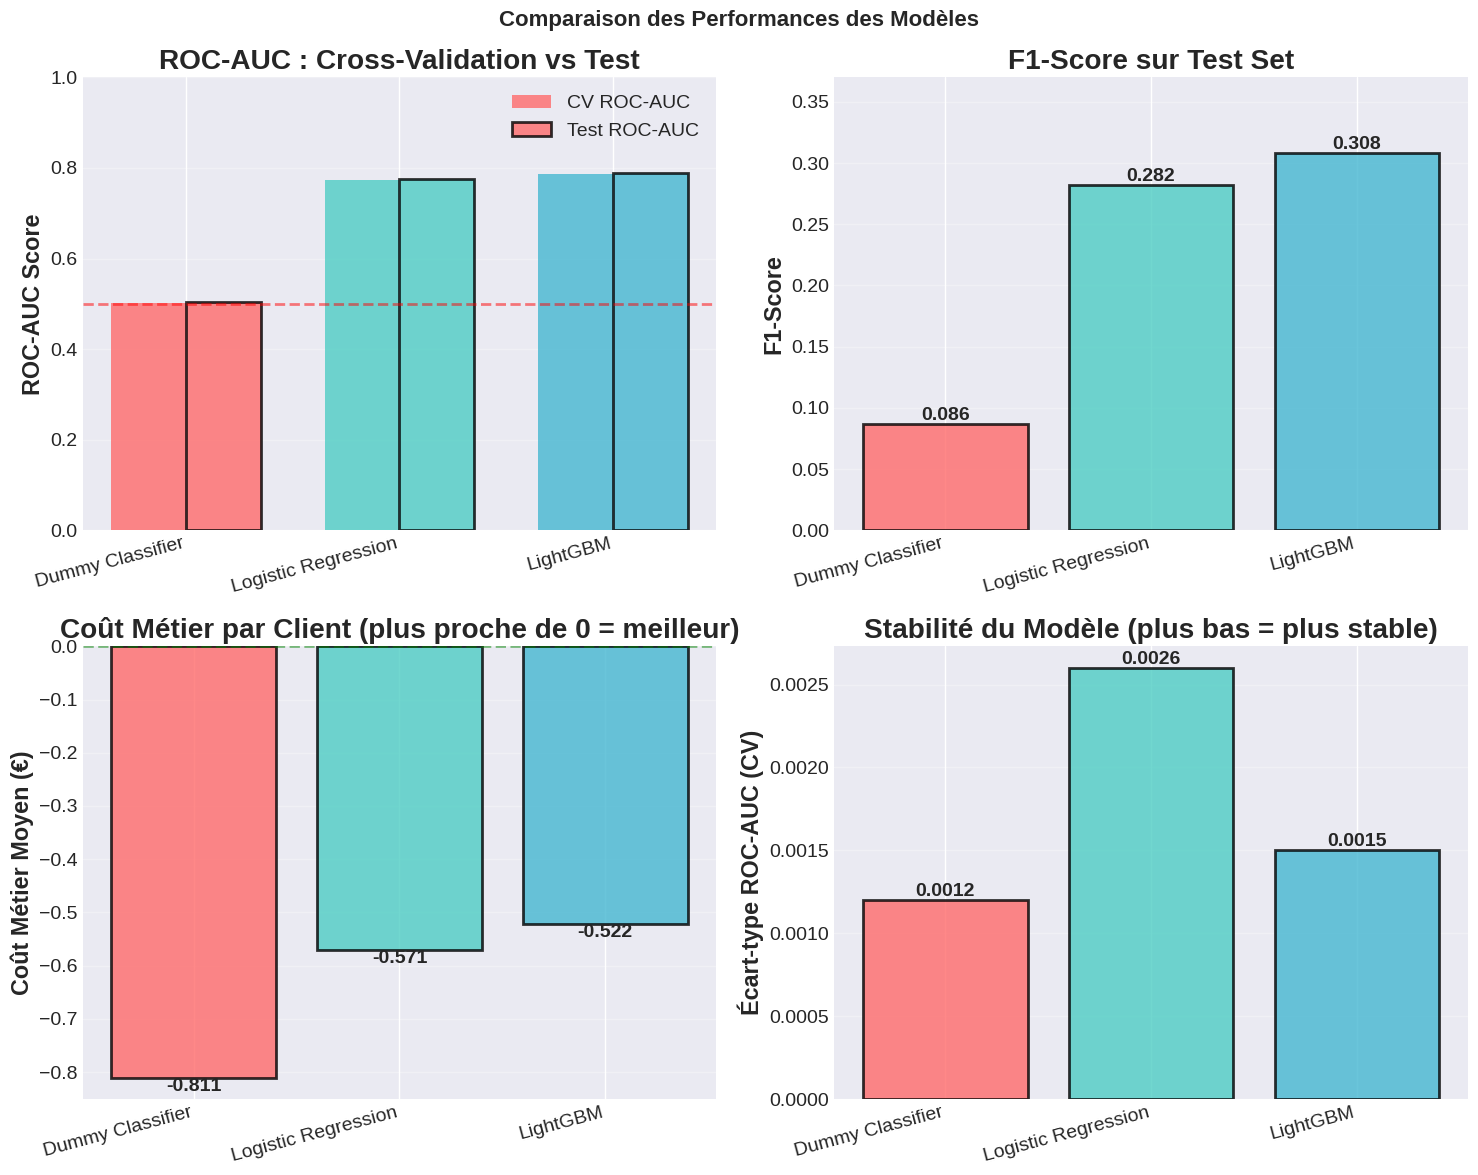


ANALYSE DES AMÉLIORATIONS PAR RAPPORT AU BASELINE

 Baseline (Dummy Classifier):
   - ROC-AUC: 0.5033
   - Coût métier: -0.8108 €/client

 Améliorations:


,Modèle,Amélioration ROC-AUC (%),Amélioration Coût (%),Gain ROC-AUC (points),Réduction Coût (€)
0,Logistic Regression,+54.14%,+29.61%,+0.2725,0.2401
1,LightGBM,+56.81%,+35.59%,+0.2859,0.2886



 RECOMMANDATION FINALE

✓ Meilleur ROC-AUC: LightGBM (0.7892)
✓ Meilleur Coût Métier: LightGBM (-0.5222 €/client)
✓ Plus Stable: Dummy Classifier (std = 0.0012)

 RECOMMANDATION GLOBALE:
   ➤ LightGBM est le meilleur choix (meilleur sur AUC ET coût métier)

 COMPARAISON TERMINÉE


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# STOCKAGE DES RÉSULTATS
# ============================================================================

# Dictionnaire pour stocker tous les résultats
results = {
    'Dummy Classifier': {
        'cv_roc_auc_mean': 0.5018,
        'cv_roc_auc_std': 0.0012,
        'test_roc_auc': 0.5033,
        'test_f1': 0.0865,
        'test_business_cost': -0.8108,
        'y_pred_proba': None,  # À remplir
        'y_pred': None  # À remplir
    },
    'Logistic Regression': {
        'cv_roc_auc_mean': 0.7737,
        'cv_roc_auc_std': 0.0026,
        'test_roc_auc': 0.7758,
        'test_f1': 0.2820,
        'test_business_cost': -0.5707,
        'y_pred_proba': None,
        'y_pred': None
    },
    'LightGBM': {
        'cv_roc_auc_mean': 0.7857,
        'cv_roc_auc_std': 0.0015,
        'test_roc_auc': 0.7892,
        'test_f1': 0.3083,
        'test_business_cost': -0.5222,
        'y_pred_proba': None,
        'y_pred': None
    }
}

# ============================================================================
# 1. TABLEAU COMPARATIF
# ============================================================================

def create_comparison_table(results):
    """Crée un DataFrame comparatif des modèles"""

    comparison_data = []
    for model_name, metrics in results.items():
        comparison_data.append({
            'Modèle': model_name,
            'CV ROC-AUC (mean)': metrics['cv_roc_auc_mean'],
            'CV ROC-AUC (std)': metrics['cv_roc_auc_std'],
            'Test ROC-AUC': metrics['test_roc_auc'],
            'Test F1-Score': metrics['test_f1'],
            'Coût Métier': metrics['test_business_cost']
        })

    df_comparison = pd.DataFrame(comparison_data)

    # Trouve l'index de la ligne avec le meilleur coût métier (valeur la plus proche de 0)
    # Comme c'est négatif, c'est la valeur maximale
    best_cost_index = df_comparison['Coût Métier'].idxmax()

    # Styling pour Jupyter
    styled_table = df_comparison.style.set_properties(**{
        'background-color': '#f0f0f0',
        'color': 'black',
        'border-color': 'white'
    }).highlight_max(subset=['Test ROC-AUC', 'Test F1-Score'],
                     color='lightgreen')

    # Surligne explicitement la ligne avec le meilleur coût métier
    styled_table = styled_table.apply(
        lambda x: ['background-color: lightgreen' if x.name == best_cost_index else '' for i in x],
        axis=1,
        subset=['Coût Métier'] # Applique le style uniquement à la colonne Coût Métier
    )


    return styled_table

print("="*80)
print("TABLEAU COMPARATIF DES MODÈLES")
print("="*80)
display(create_comparison_table(results))

# ============================================================================
# 2. GRAPHIQUES DE COMPARAISON
# ============================================================================

def plot_model_comparison(results):
    """Crée des graphiques de comparaison des modèles"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comparaison des Performances des Modèles', fontsize=16, fontweight='bold')

    models = list(results.keys())
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    # 1. ROC-AUC (CV et Test)
    ax1 = axes[0, 0]
    cv_aucs = [results[m]['cv_roc_auc_mean'] for m in models]
    test_aucs = [results[m]['test_roc_auc'] for m in models]

    x = np.arange(len(models))
    width = 0.35

    ax1.bar(x - width/2, cv_aucs, width, label='CV ROC-AUC', alpha=0.8, color=colors)
    ax1.bar(x + width/2, test_aucs, width, label='Test ROC-AUC', alpha=0.8,
            color=[c for c in colors], edgecolor='black', linewidth=2)

    ax1.set_ylabel('ROC-AUC Score', fontweight='bold')
    ax1.set_title('ROC-AUC : Cross-Validation vs Test', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=15, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim([0, 1])

    # Ligne de base à 0.5 (aléatoire)
    ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Random')

    # 2. F1-Score
    ax2 = axes[0, 1]
    f1_scores = [results[m]['test_f1'] for m in models]
    bars = ax2.bar(models, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax2.set_ylabel('F1-Score', fontweight='bold')
    ax2.set_title('F1-Score sur Test Set', fontweight='bold')
    ax2.set_xticklabels(models, rotation=15, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim([0, max(f1_scores) * 1.2])

    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    # 3. Coût Métier (négatif = coût, donc plus proche de 0 = meilleur)
    ax3 = axes[1, 0]
    business_costs = [results[m]['test_business_cost'] for m in models]
    bars = ax3.bar(models, business_costs, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax3.set_ylabel('Coût Métier Moyen (€)', fontweight='bold')
    ax3.set_title('Coût Métier par Client (plus proche de 0 = meilleur)', fontweight='bold')
    ax3.set_xticklabels(models, rotation=15, ha='right')
    ax3.grid(axis='y', alpha=0.3)
    ax3.axhline(y=0, color='green', linestyle='--', linewidth=2, alpha=0.5)

    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top',
                fontweight='bold')

    # 4. Variance CV (stabilité du modèle)
    ax4 = axes[1, 1]
    cv_stds = [results[m]['cv_roc_auc_std'] for m in models]
    bars = ax4.bar(models, cv_stds, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax4.set_ylabel('Écart-type ROC-AUC (CV)', fontweight='bold')
    ax4.set_title('Stabilité du Modèle (plus bas = plus stable)', fontweight='bold')
    ax4.set_xticklabels(models, rotation=15, ha='right')
    ax4.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("GRAPHIQUES DE COMPARAISON")
print("="*80)
plot_model_comparison(results)

# ============================================================================
# 3. COURBES ROC COMPARÉES
# ============================================================================

def plot_roc_curves(results, y_test):
    """Compare les courbes ROC de tous les modèles"""

    plt.figure(figsize=(10, 8))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    for i, (model_name, metrics) in enumerate(results.items()):
        if metrics['y_pred_proba'] is not None:
            fpr, tpr, _ = roc_curve(y_test, metrics['y_pred_proba'])
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, color=colors[i], lw=3,
                    label=f'{model_name} (AUC = {roc_auc:.4f})')

    # Ligne de base (classificateur aléatoire)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--',
             label='Aléatoire (AUC = 0.5000)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12, fontweight='bold')
    plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12, fontweight='bold')
    plt.title('Courbes ROC - Comparaison des Modèles', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 4. MATRICES DE CONFUSION (si y_pred disponibles)
# ============================================================================

def plot_confusion_matrices(results, y_test):
    """Affiche les matrices de confusion de tous les modèles"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Matrices de Confusion', fontsize=16, fontweight='bold')

    for i, (model_name, metrics) in enumerate(results.items()):
        if metrics['y_pred'] is not None:
            cm = confusion_matrix(y_test, metrics['y_pred'])

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                       cbar_kws={'label': 'Nombre de prédictions'})
            axes[i].set_title(model_name, fontweight='bold')
            axes[i].set_ylabel('Vraie Classe', fontweight='bold')
            axes[i].set_xlabel('Classe Prédite', fontweight='bold')
            axes[i].set_xticklabels(['Pas Défaut (0)', 'Défaut (1)'])
            axes[i].set_yticklabels(['Pas Défaut (0)', 'Défaut (1)'])

            # Ajouter les taux
            tn, fp, fn, tp = cm.ravel()
            total = tn + fp + fn + tp
            axes[i].text(0.5, -0.15,
                        f'Accuracy: {(tn+tp)/total:.3f}\n'
                        f'FP: {fp} ({fp/total*100:.1f}%) | FN: {fn} ({fn/total*100:.1f}%)',
                        transform=axes[i].transAxes, ha='center',
                        fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

# ============================================================================
# 5. ANALYSE DES GAINS PAR RAPPORT AU BASELINE
# ============================================================================

def analyze_improvements(results):
    """Analyse les améliorations par rapport au Dummy Classifier"""

    baseline_model = 'Dummy Classifier'
    baseline_auc = results[baseline_model]['test_roc_auc']
    baseline_cost = results[baseline_model]['test_business_cost']

    print("\n" + "="*80)
    print("ANALYSE DES AMÉLIORATIONS PAR RAPPORT AU BASELINE")
    print("="*80)

    improvements = []
    for model_name, metrics in results.items():
        if model_name != baseline_model:
            auc_improvement = ((metrics['test_roc_auc'] - baseline_auc) / baseline_auc) * 100
            cost_improvement = ((metrics['test_business_cost'] - baseline_cost) / abs(baseline_cost)) * 100

            improvements.append({
                'Modèle': model_name,
                'Amélioration ROC-AUC (%)': f"+{auc_improvement:.2f}%",
                'Amélioration Coût (%)': f"+{cost_improvement:.2f}%",
                'Gain ROC-AUC (points)': f"+{(metrics['test_roc_auc'] - baseline_auc):.4f}",
                'Réduction Coût (€)': f"{(metrics['test_business_cost'] - baseline_cost):.4f}"
            })

    df_improvements = pd.DataFrame(improvements)

    print(f"\n Baseline (Dummy Classifier):")
    print(f"   - ROC-AUC: {baseline_auc:.4f}")
    print(f"   - Coût métier: {baseline_cost:.4f} €/client")
    print(f"\n Améliorations:")
    display(df_improvements)

    return df_improvements

analyze_improvements(results)

# ============================================================================
# 6. RECOMMANDATION FINALE
# ============================================================================

def recommend_best_model(results):
    """Recommande le meilleur modèle selon plusieurs critères"""

    print("\n" + "="*80)
    print(" RECOMMANDATION FINALE")
    print("="*80)

    # Meilleur ROC-AUC
    best_auc_model = max(results.items(), key=lambda x: x[1]['test_roc_auc'])
    print(f"\n✓ Meilleur ROC-AUC: {best_auc_model[0]} ({best_auc_model[1]['test_roc_auc']:.4f})")

    # Meilleur coût métier
    best_cost_model = max(results.items(), key=lambda x: x[1]['test_business_cost'])
    print(f"✓ Meilleur Coût Métier: {best_cost_model[0]} ({best_cost_model[1]['test_business_cost']:.4f} €/client)")

    # Plus stable (CV variance)
    most_stable_model = min(results.items(), key=lambda x: x[1]['cv_roc_auc_std'])
    print(f"✓ Plus Stable: {most_stable_model[0]} (std = {most_stable_model[1]['cv_roc_auc_std']:.4f})")

    # Recommandation globale
    print(f"\n RECOMMANDATION GLOBALE:")
    if best_auc_model[0] == best_cost_model[0]:
        print(f"   ➤ {best_auc_model[0]} est le meilleur choix (meilleur sur AUC ET coût métier)")
    else:
        print(f"   ➤ {best_cost_model[0]} pour optimiser le coût métier")
        print(f"   ➤ {best_auc_model[0]} pour maximiser la performance prédictive (ROC-AUC)")

recommend_best_model(results)

print("\n" + "="*80)
print(" COMPARAISON TERMINÉE")
print("="*80)

In [50]:
# Trouve le seuil optimal pour minimiser le coût métier
thresholds = np.arange(0.1, 0.9, 0.01)
costs = []

for threshold in thresholds:
    # Utilise la variable y_pred_proba qui contient les prédictions du modèle LightGBM
    cost = business_cost_score(y_test, y_pred_proba, threshold=threshold)
    costs.append(cost)

optimal_threshold = thresholds[np.argmax(costs)]
print(f"Seuil optimal : {optimal_threshold:.2f}")
print(f"Coût optimal : {max(costs):.4f}")

Seuil optimal : 0.50
Coût optimal : -0.4837


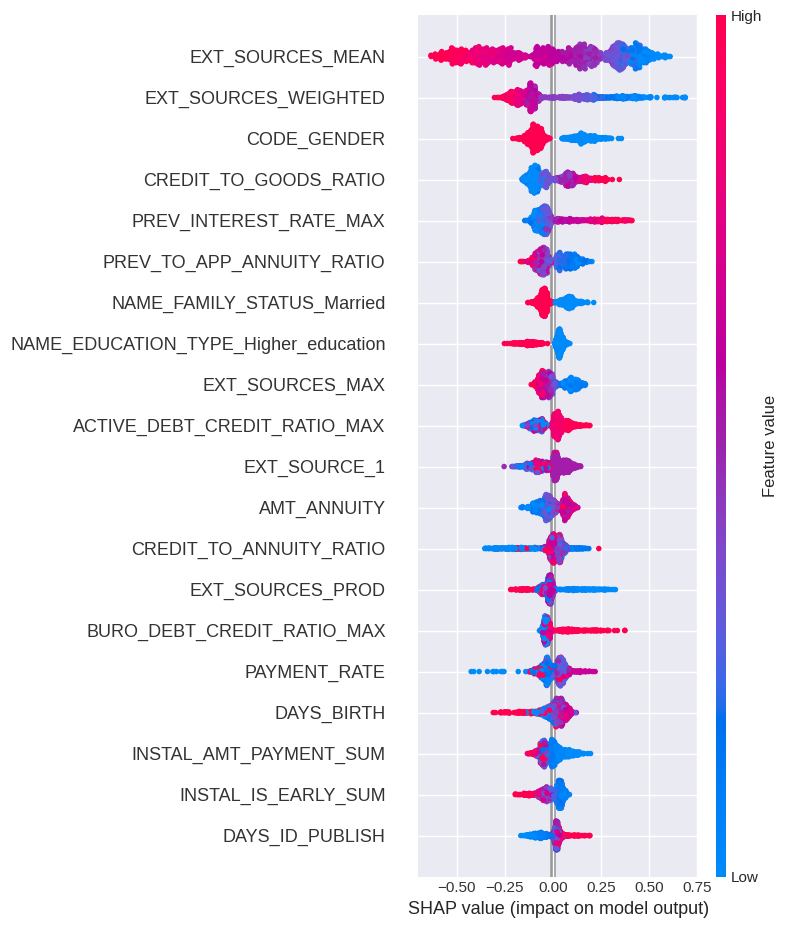

In [51]:
import shap

# Feature importance native LightGBM
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_clf.feature_importances_
}).sort_values('importance', ascending=False).head(20)

# SHAP values
explainer = shap.TreeExplainer(lgbm_clf)
shap_values = explainer.shap_values(X_test[:1000])  # Sur échantillon
shap.summary_plot(shap_values, X_test[:1000])

In [52]:
# Matrice de confusion avec seuil optimal
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_optimal)

# Analyse des faux négatifs (plus coûteux)
false_negatives = X_test[(y_test == 1) & (y_pred_optimal == 0)]
print(f"Analyse des {len(false_negatives)} faux négatifs...")

Analyse des 1656 faux négatifs...


In [53]:
# ============================================================================
# IDENTIFICATION DES FAUX NÉGATIFS
# ============================================================================

optimal_threshold = 0.50  # Ton seuil optimal
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Indices des différentes catégories
true_positives_idx = (y_test == 1) & (y_pred_optimal == 1)
false_negatives_idx = (y_test == 1) & (y_pred_optimal == 0)  # Les plus coûteux !
true_negatives_idx = (y_test == 0) & (y_pred_optimal == 0)
false_positives_idx = (y_test == 0) & (y_pred_optimal == 1)

print("=" * 80)
print("RÉPARTITION DES PRÉDICTIONS")
print("=" * 80)
print(f"✓ Vrais Positifs (TP)  : {true_positives_idx.sum():6d} - Défauts correctement détectés")
print(f"Faux Négatifs (FN)  : {false_negatives_idx.sum():6d} - Défauts NON détectés (COÛTEUX !)")
print(f"✓ Vrais Négatifs (TN)  : {true_negatives_idx.sum():6d} - Bons clients correctement acceptés")
print(f" Faux Positifs (FP)   : {false_positives_idx.sum():6d} - Bons clients refusés")

# Coût total
fn_cost = false_negatives_idx.sum() * 10  # Coût unitaire = 10
fp_cost = false_positives_idx.sum() * 1   # Coût unitaire = 1
total_cost = fn_cost + fp_cost

print(f"\n COÛT TOTAL:")
print(f"  • Coût FN (10€/client) : {fn_cost:,}€")
print(f"  • Coût FP (1€/client)  : {fp_cost:,}€")
print(f"  • COÛT TOTAL           : {total_cost:,}€")

RÉPARTITION DES PRÉDICTIONS
✓ Vrais Positifs (TP)  :   3309 - Défauts correctement détectés
Faux Négatifs (FN)  :   1656 - Défauts NON détectés (COÛTEUX !)
✓ Vrais Négatifs (TN)  :  43346 - Bons clients correctement acceptés
 Faux Positifs (FP)   :  13191 - Bons clients refusés

 COÛT TOTAL:
  • Coût FN (10€/client) : 16,560€
  • Coût FP (1€/client)  : 13,191€
  • COÛT TOTAL           : 29,751€


In [54]:
# ============================================================================
# COMPARAISON PROFILS : FAUX NÉGATIFS vs VRAIS POSITIFS
# ============================================================================

print("\n" + "=" * 80)
print("COMPARAISON DE PROFILS : FN vs TP")
print("=" * 80)

# Extraction des données
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

fn_data = X_test_reset[false_negatives_idx.values]
tp_data = X_test_reset[true_positives_idx.values]

# Features les plus importantes à comparer
top_features = [
    'EXT_SOURCES_MEAN', 'EXT_SOURCES_WEIGHTED', 'CODE_GENDER',
    'CREDIT_TO_GOODS_RATIO', 'PAYMENT_RATE', 'DAYS_BIRTH',
    'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY'
]

# Tableau comparatif
comparison = pd.DataFrame({
    'Feature': top_features,
    'FN (non détectés)': [fn_data[f].mean() if f in fn_data.columns else np.nan for f in top_features],
    'TP (détectés)': [tp_data[f].mean() if f in tp_data.columns else np.nan for f in top_features],
})

comparison['Différence (%)'] = ((comparison['FN (non détectés)'] - comparison['TP (détectés)']) /
                                 comparison['TP (détectés)'].abs() * 100)

print("\n MOYENNES DES FEATURES CLÉS:")
print(comparison.to_string(index=False))



COMPARAISON DE PROFILS : FN vs TP

 MOYENNES DES FEATURES CLÉS:
              Feature  FN (non détectés)  TP (détectés)  Différence (%)
     EXT_SOURCES_MEAN           0.522240       0.384921       35.674349
 EXT_SOURCES_WEIGHTED           4.720659       3.400849       38.808247
          CODE_GENDER           0.662440       0.525536       26.050183
CREDIT_TO_GOODS_RATIO           1.121383       1.169275       -4.095858
         PAYMENT_RATE           0.051523       0.055971       -7.947618
           DAYS_BIRTH      -16499.620773  -14228.288909      -15.963493
           AMT_CREDIT      617248.584239  529825.947416       16.500256
     AMT_INCOME_TOTAL      168975.309783  158776.432004        6.423420
          AMT_ANNUITY       26908.038043   26254.181777        2.490484



 STATISTIQUES DES PROBABILITÉS PRÉDITES:
  • FN moyenne : 0.320 (écart-type: 0.119)
  • TP moyenne : 0.718 (écart-type: 0.116)
  • Les FN ont des probabilités proches du seuil → difficiles à détecter


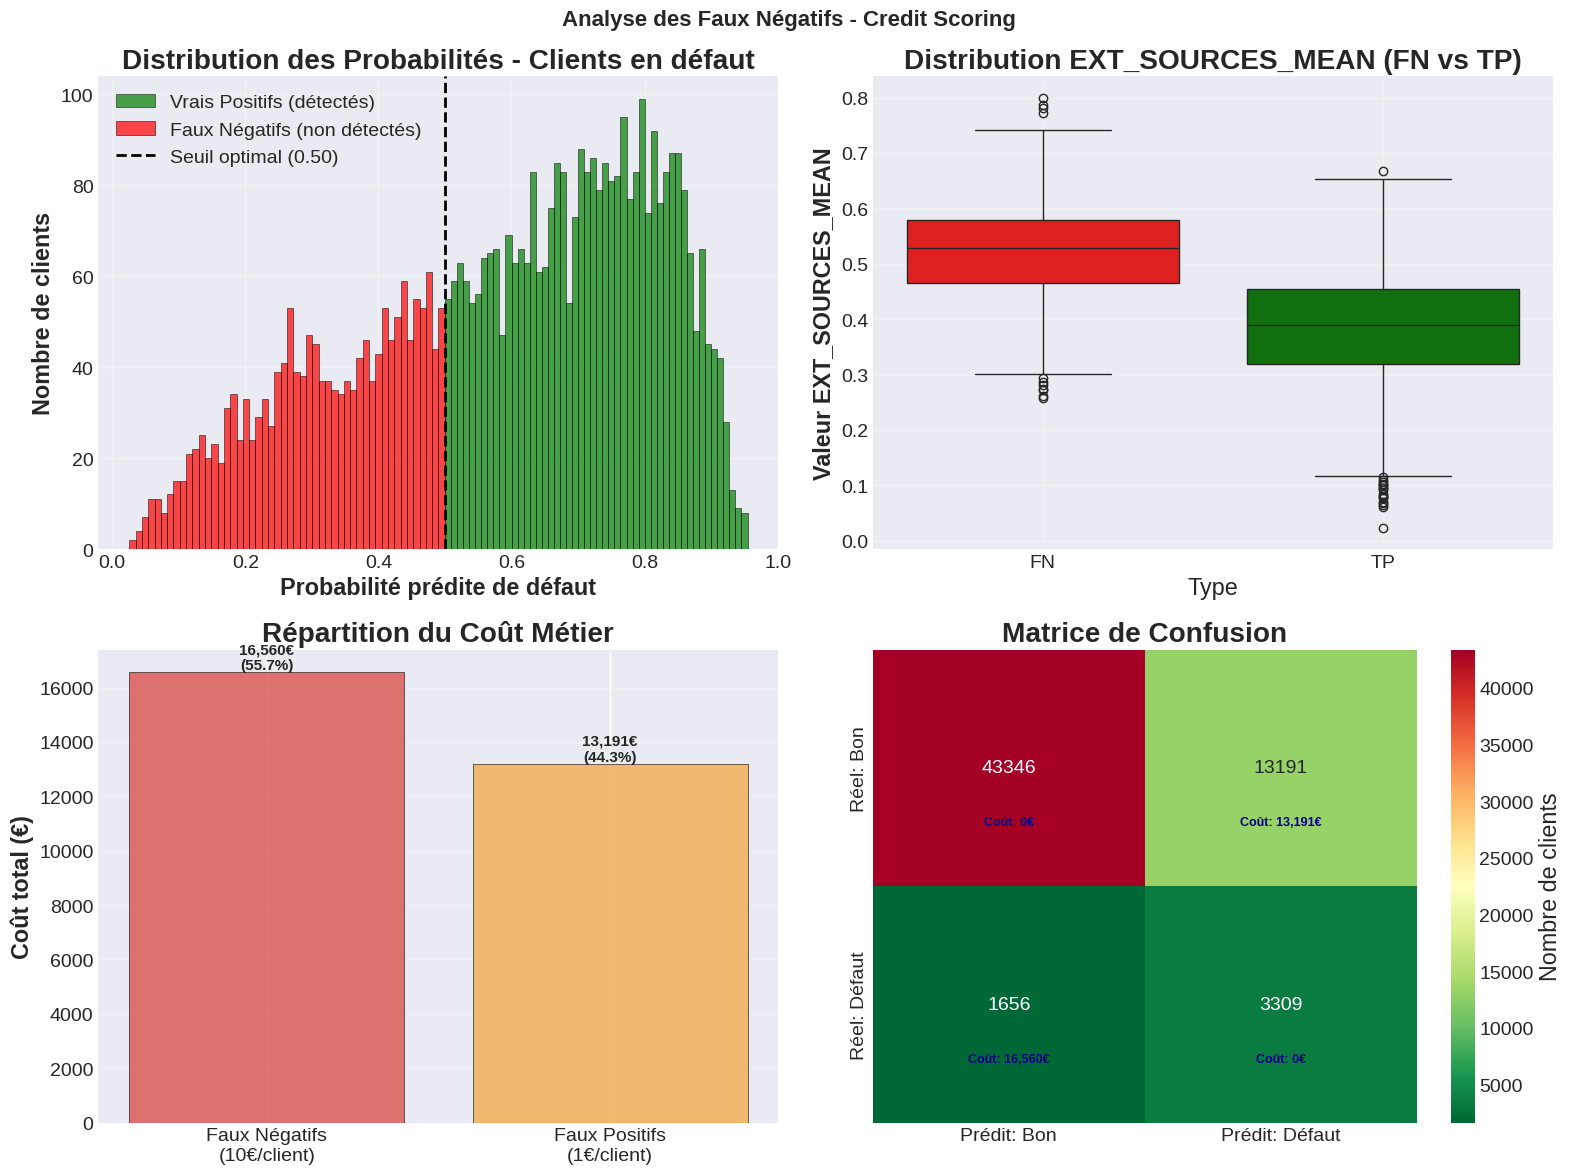

In [55]:
# ============================================================================
# DISTRIBUTION DES PROBABILITÉS PRÉDITES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse des Faux Négatifs - Credit Scoring', fontsize=16, fontweight='bold')

# --- GRAPHIQUE 1 : Distribution des probabilités ---
ax1 = axes[0, 0]

# Probabilités pour les défauts (y=1)
fn_probs = y_pred_proba[false_negatives_idx.values]
tp_probs = y_pred_proba[true_positives_idx.values]

ax1.hist(tp_probs, bins=50, alpha=0.7, label='Vrais Positifs (détectés)', color='green', edgecolor='black')
ax1.hist(fn_probs, bins=50, alpha=0.7, label='Faux Négatifs (non détectés)', color='red', edgecolor='black')
ax1.axvline(optimal_threshold, color='black', linestyle='--', linewidth=2, label=f'Seuil optimal ({optimal_threshold:.2f})') # Added formatting
ax1.set_xlabel('Probabilité prédite de défaut', fontweight='bold')
ax1.set_ylabel('Nombre de clients', fontweight='bold')
ax1.set_title('Distribution des Probabilités - Clients en défaut', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

print(f"\n STATISTIQUES DES PROBABILITÉS PRÉDITES:")
print(f"  • FN moyenne : {fn_probs.mean():.3f} (écart-type: {fn_probs.std():.3f})")
print(f"  • TP moyenne : {tp_probs.mean():.3f} (écart-type: {tp_probs.std():.3f})")
print(f"  • Les FN ont des probabilités proches du seuil → difficiles à détecter")

# --- GRAPHIQUE 2 : Box plots des features clés ---
ax2 = axes[0, 1]

# Préparer les données pour le box plot
if 'EXT_SOURCES_MEAN' in fn_data.columns and 'EXT_SOURCES_MEAN' in tp_data.columns:
    # Combine the data for the selected feature
    combined_data = pd.concat([
        fn_data[['EXT_SOURCES_MEAN']].assign(Type='FN'),
        tp_data[['EXT_SOURCES_MEAN']].assign(Type='TP')
    ])

    sns.boxplot(data=combined_data, x='Type', y='EXT_SOURCES_MEAN', ax=ax2, palette=['red', 'green'])
    ax2.set_title('Distribution EXT_SOURCES_MEAN (FN vs TP)', fontweight='bold') # Added (FN vs TP)
    ax2.set_ylabel('Valeur EXT_SOURCES_MEAN', fontweight='bold') # More specific label
    ax2.grid(alpha=0.3)

# --- GRAPHIQUE 3 : Coût par catégorie ---
ax3 = axes[1, 0]

categories = ['Faux Négatifs\n(10€/client)', 'Faux Positifs\n(1€/client)']
costs = [fn_cost, fp_cost]
colors = ['#d9534f', '#f0ad4e']

bars = ax3.bar(categories, costs, color=colors, alpha=0.8, edgecolor='black')
ax3.set_ylabel('Coût total (€)', fontweight='bold')
ax3.set_title('Répartition du Coût Métier', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Annotations
for bar, cost in zip(bars, costs):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{cost:,}€\n({cost/total_cost*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# --- GRAPHIQUE 4 : Matrice de confusion ---
ax4 = axes[1, 1]

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', ax=ax4,
            xticklabels=['Prédit: Bon', 'Prédit: Défaut'],
            yticklabels=['Réel: Bon', 'Réel: Défaut'],
            cbar_kws={'label': 'Nombre de clients'})

ax4.set_title('Matrice de Confusion', fontweight='bold')

# Ajouter les coûts
for i in range(2):
    for j in range(2):
        if i == 1 and j == 0:  # FN
            cost_text = f"\nCoût: {cm[i,j] * 10:,}€"
        elif i == 0 and j == 1:  # FP
            cost_text = f"\nCoût: {cm[i,j] * 1:,}€"
        else:
            cost_text = "\nCoût: 0€"

        ax4.text(j + 0.5, i + 0.7, cost_text,
                ha='center', va='center', fontsize=9, color='darkblue', fontweight='bold')

plt.tight_layout()
plt.savefig('false_negatives_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [56]:
# ============================================================================
# PROFIL-TYPE DU FAUX NÉGATIF
# ============================================================================

print("\n" + "=" * 80)
print("PROFIL-TYPE DU FAUX NÉGATIF (Client défaillant non détecté)")
print("=" * 80)

print("\n CARACTÉRISTIQUES COMMUNES:")

# Calculer les percentiles
if 'EXT_SOURCES_MEAN' in fn_data.columns:
    ext_source_percentile = (fn_data['EXT_SOURCES_MEAN'].mean() /
                             X_test_reset['EXT_SOURCES_MEAN'].mean() * 100)
    print(f"  • Score externe : {fn_data['EXT_SOURCES_MEAN'].mean():.3f} "
          f"({ext_source_percentile:.0f}% de la moyenne)")

if 'AMT_CREDIT' in fn_data.columns:
    print(f"  • Montant crédit moyen : {fn_data['AMT_CREDIT'].mean():,.0f}€")

if 'AMT_INCOME_TOTAL' in fn_data.columns:
    print(f"  • Revenu moyen : {fn_data['AMT_INCOME_TOTAL'].mean():,.0f}€")

if 'DAYS_BIRTH' in fn_data.columns:
    age_years = -fn_data['DAYS_BIRTH'].mean() / 365
    print(f"  • Âge moyen : {age_years:.1f} ans")

print(f"\n INSIGHT CLÉ:")
print(f"  Les FN ont des probabilités moyennes de {fn_probs.mean():.3f}, juste en dessous")
print(f"  du seuil de {optimal_threshold}. Ce sont des cas limites difficiles à classifier.")


PROFIL-TYPE DU FAUX NÉGATIF (Client défaillant non détecté)

 CARACTÉRISTIQUES COMMUNES:
  • Score externe : 0.522 (102% de la moyenne)
  • Montant crédit moyen : 617,249€
  • Revenu moyen : 168,975€
  • Âge moyen : 45.2 ans

 INSIGHT CLÉ:
  Les FN ont des probabilités moyennes de 0.320, juste en dessous
  du seuil de 0.5. Ce sont des cas limites difficiles à classifier.


In [58]:
import pickle
import pandas as pd
from lightgbm import LGBMClassifier

# ============================================================================
# SAUVEGARDE DU MODÈLE ET DES OBJETS NÉCESSAIRES
# ============================================================================

print(" Sauvegarde du modèle et des composants...")

# 1. Sauvegarde le modèle LightGBM
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(lgbm_clf, f)
print("✓ Modèle LightGBM sauvegardé : lgbm_model.pkl")

# 2. Sauvegarde l'imputer (pour gérer les NaN)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)

with open('imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)
print("✓ Imputer sauvegardé : imputer.pkl")

# 3. Sauvegarde la liste des features attendues
feature_names = list(X_train.columns)
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print("✓ Noms des features sauvegardés : feature_names.pkl")

# 4. Sauvegarde un exemple de données pour tester l'API
example_data = X_test.iloc[0:5].to_dict('records')
with open('example_data.pkl', 'wb') as f:
    pickle.dump(example_data, f)
print("✓ Données d'exemple sauvegardées : example_data.pkl")

print("\n" + "=" * 60)
print(" TOUT EST SAUVEGARDÉ !")
print("=" * 60)
print(f" Nombre de features : {len(feature_names)}")
print(f" Performance du modèle : ROC-AUC = {roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1]):.4f}")

 Sauvegarde du modèle et des composants...
✓ Modèle LightGBM sauvegardé : lgbm_model.pkl
✓ Imputer sauvegardé : imputer.pkl
✓ Noms des features sauvegardés : feature_names.pkl
✓ Données d'exemple sauvegardées : example_data.pkl

 TOUT EST SAUVEGARDÉ !
 Nombre de features : 777
 Performance du modèle : ROC-AUC = 0.7892


In [59]:
# TÉLÉCHARGEMENT DES RUNS MLFLOW POUR L'UI
import shutil
from google.colab import files
import os

# Vérifie que mlruns existe
if os.path.exists('./mlruns'):
    print(" Dossier mlruns trouvé !")

    # Liste les runs
    for root, dirs, files_list in os.walk('./mlruns'):
        if 'meta.yaml' in files_list:
            print(f"   Run trouvé : {root}")

    # Compresse tout
    shutil.make_archive('mlruns', 'zip', './mlruns')
    print("\n Archive mlruns.zip créée !")

    # Télécharge
    files.download('mlruns.zip')
    print(" Téléchargement lancé...")
else:
    print(" Dossier mlruns introuvable !")

 Dossier mlruns trouvé !
   Run trouvé : ./mlruns/208818114892204756
   Run trouvé : ./mlruns/208818114892204756/62ef289b259948b99c439b17f83fb7b4
   Run trouvé : ./mlruns/208818114892204756/62ef289b259948b99c439b17f83fb7b4/outputs/m-13e65c3fa7764fcf85ecee063e3a3362
   Run trouvé : ./mlruns/208818114892204756/models/m-13e65c3fa7764fcf85ecee063e3a3362
   Run trouvé : ./mlruns/208818114892204756/models/m-e1d67a1c56414efe88cd21069d475a71
   Run trouvé : ./mlruns/208818114892204756/models/m-fc0a9c4a6ea04b00b68efd77e9fecd33
   Run trouvé : ./mlruns/208818114892204756/75b08051e0a943429aa75e0af8c7a2c6
   Run trouvé : ./mlruns/208818114892204756/75b08051e0a943429aa75e0af8c7a2c6/outputs/m-e1d67a1c56414efe88cd21069d475a71
   Run trouvé : ./mlruns/208818114892204756/1870f7cb7b7f4aa1993df0bc8d9f1d2a
   Run trouvé : ./mlruns/208818114892204756/1870f7cb7b7f4aa1993df0bc8d9f1d2a/outputs/m-fc0a9c4a6ea04b00b68efd77e9fecd33
   Run trouvé : ./mlruns/0

 Archive mlruns.zip créée !


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Téléchargement lancé...
